In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
from datetime import datetime

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity_Regression
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

from params import PROJECT_PATH

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING
NET_PARAMS = params.learning.NET_PARAMS

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),

    # Randomly adds a black patch to the image
    Cutout(0.5),
    
    # Randomly cast a shadow on the image
    Shadowcasting(0.5),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_train.csv",
    images_directory=params.learning.DATASET / "images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_train.csv",
    images_directory=params.learning.DATASET / "images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_test.csv",
    images_directory=params.learning.DATASET / "images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

69.0 % of the data for training (145 samples)
15.0 % of the data for validation (32 samples)
15.0 % of the data for testing (32 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model

model = ResNet18Velocity_Regression(nb_input_channels=NET_PARAMS["nb_input_channels"],
                                    nb_input_features=NET_PARAMS["nb_input_features"],
                                    nb_classes=1).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity_Regression(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [11]:
# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer, total_iters=LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the loss and accuracy values
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_regression_loss = train(model,
                                  device,
                                  train_loader,
                                  optimizer,
                                  scheduler,
                                  criterion_regression,
                                  epoch)
    
    # Validation
    val_regression_loss = validate(model,
                                   device,
                                   val_loader,
                                   criterion_regression,
                                   epoch) 
    
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)

    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  2.982493686676025
Validation regression loss:  2.998807430267334


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  2.79766526222229
Validation regression loss:  2.9297168254852295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  2.4035228729248046
Validation regression loss:  2.6899523735046387


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  2.0777539014816284
Validation regression loss:  2.3662538528442383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  1.7229915618896485
Validation regression loss:  2.015986204147339


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  1.4483298301696776
Validation regression loss:  1.6924946308135986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  1.236101007461548
Validation regression loss:  1.4186618328094482


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  1.005613112449646
Validation regression loss:  1.2109766006469727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.8569223046302795
Validation regression loss:  1.033620834350586


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.7837937235832214
Validation regression loss:  0.89556884765625


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.6555238485336303
Validation regression loss:  0.7805817127227783


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.538230013847351
Validation regression loss:  0.6928349733352661


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.47122675776481626
Validation regression loss:  0.6197112202644348


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.416087931394577
Validation regression loss:  0.5617750883102417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.3912182241678238
Validation regression loss:  0.508141815662384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.38528038263320924
Validation regression loss:  0.46991783380508423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.3751980125904083
Validation regression loss:  0.4471663236618042


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.3500184953212738
Validation regression loss:  0.42294609546661377


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.3571905791759491
Validation regression loss:  0.4013456106185913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.3460195749998093
Validation regression loss:  0.38555702567100525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.4273511588573456
Validation regression loss:  0.37516310811042786


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2960518389940262
Validation regression loss:  0.36759695410728455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.30774500370025637
Validation regression loss:  0.36209797859191895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.29255170226097105
Validation regression loss:  0.3538397550582886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.31663729548454284
Validation regression loss:  0.3510589897632599


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.28748815357685087
Validation regression loss:  0.34227341413497925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.3276759207248688
Validation regression loss:  0.33339816331863403


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.26949223279953005
Validation regression loss:  0.3268178105354309


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.25940478444099424
Validation regression loss:  0.3233194947242737


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2809804767370224
Validation regression loss:  0.31622403860092163


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.26078158617019653
Validation regression loss:  0.3151071071624756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.27157009541988375
Validation regression loss:  0.3111233711242676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2853295147418976
Validation regression loss:  0.31047725677490234


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2724768042564392
Validation regression loss:  0.3074902892112732


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2428401529788971
Validation regression loss:  0.3047311305999756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.26097711622715
Validation regression loss:  0.30411428213119507


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2516312837600708
Validation regression loss:  0.3021937906742096


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24702482521533967
Validation regression loss:  0.2990293502807617


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2478444218635559
Validation regression loss:  0.295544296503067


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2645149379968643
Validation regression loss:  0.293620765209198


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24444791078567504
Validation regression loss:  0.29227495193481445


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24395095705986022
Validation regression loss:  0.28930187225341797


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2430354595184326
Validation regression loss:  0.28964072465896606


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22727180421352386
Validation regression loss:  0.2884863018989563


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24657185077667237
Validation regression loss:  0.2880995273590088


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2408980041742325
Validation regression loss:  0.28967201709747314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2494539886713028
Validation regression loss:  0.28881269693374634


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23827063143253327
Validation regression loss:  0.28880974650382996


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23593042194843292
Validation regression loss:  0.2885719835758209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24130671322345734
Validation regression loss:  0.28752198815345764


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24030071794986724
Validation regression loss:  0.28785189986228943


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22647899091243745
Validation regression loss:  0.28764808177948


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23011946976184844
Validation regression loss:  0.2872827351093292


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24428239166736604
Validation regression loss:  0.2881006598472595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22487973123788835
Validation regression loss:  0.28833746910095215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23683639764785766
Validation regression loss:  0.29091230034828186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23171832412481308
Validation regression loss:  0.29371798038482666


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22252801358699797
Validation regression loss:  0.2897157073020935


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23357428312301637
Validation regression loss:  0.2890155017375946


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23716415762901305
Validation regression loss:  0.28980326652526855


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23455752432346344
Validation regression loss:  0.2871958613395691


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2256775140762329
Validation regression loss:  0.28728413581848145


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21113355755805968
Validation regression loss:  0.2874529957771301


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2484901487827301
Validation regression loss:  0.2865724563598633


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21465750336647033
Validation regression loss:  0.2901788055896759


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23304195404052735
Validation regression loss:  0.29233458638191223


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2180780977010727
Validation regression loss:  0.2978401780128479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22787290513515474
Validation regression loss:  0.2985819876194


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.205310620367527
Validation regression loss:  0.3022457957267761


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21099653244018554
Validation regression loss:  0.2984673082828522


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21743285208940505
Validation regression loss:  0.30084699392318726


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2155403971672058
Validation regression loss:  0.3006824553012848


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22184890508651733
Validation regression loss:  0.3032909333705902


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20654779076576232
Validation regression loss:  0.2976549565792084


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20921663641929628
Validation regression loss:  0.3079211711883545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22673599123954774
Validation regression loss:  0.311659038066864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.23516903817653656
Validation regression loss:  0.30319470167160034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22795644402503967
Validation regression loss:  0.30140653252601624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24974308907985687
Validation regression loss:  0.296404629945755


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2154984399676323
Validation regression loss:  0.2988058030605316


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2109201192855835
Validation regression loss:  0.2980096638202667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.24221672713756562
Validation regression loss:  0.298626184463501


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22569549083709717
Validation regression loss:  0.2979448735713959


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22012039124965668
Validation regression loss:  0.3007819354534149


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22046883702278136
Validation regression loss:  0.2954212725162506


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19908187091350554
Validation regression loss:  0.29533085227012634


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21177867650985718
Validation regression loss:  0.2955525517463684


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22304427325725557
Validation regression loss:  0.30291587114334106


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2176760047674179
Validation regression loss:  0.3055708110332489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22099413573741913
Validation regression loss:  0.30749934911727905


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2246284157037735
Validation regression loss:  0.30431461334228516


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20863564908504487
Validation regression loss:  0.3033294081687927


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22552237808704376
Validation regression loss:  0.3054654598236084


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2173686742782593
Validation regression loss:  0.30409717559814453


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21730404496192932
Validation regression loss:  0.302972674369812


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21662941575050354
Validation regression loss:  0.305386483669281


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1978125736117363
Validation regression loss:  0.3041802942752838


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2196488857269287
Validation regression loss:  0.30650508403778076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20958325266838074
Validation regression loss:  0.3113775849342346


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20947997868061066
Validation regression loss:  0.31388527154922485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22185360491275788
Validation regression loss:  0.31098610162734985


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21256551742553711
Validation regression loss:  0.3118896186351776


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22014403343200684
Validation regression loss:  0.307218074798584


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22749956846237182
Validation regression loss:  0.3098105490207672


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22609380185604094
Validation regression loss:  0.31100180745124817


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20108356773853303
Validation regression loss:  0.3146401643753052


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20039971470832824
Validation regression loss:  0.3115151524543762


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21215762197971344
Validation regression loss:  0.3122071623802185


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2079290419816971
Validation regression loss:  0.3054244816303253


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21291952729225158
Validation regression loss:  0.30546098947525024


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2222263514995575
Validation regression loss:  0.30801597237586975


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2172098070383072
Validation regression loss:  0.30812621116638184


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21914159655570983
Validation regression loss:  0.30437368154525757


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20698750019073486
Validation regression loss:  0.30860280990600586


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2105964571237564
Validation regression loss:  0.30602115392684937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19669072180986405
Validation regression loss:  0.30862581729888916


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2104131668806076
Validation regression loss:  0.31254953145980835


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20225683152675628
Validation regression loss:  0.3079915940761566


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19683570563793182
Validation regression loss:  0.30750858783721924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1978901743888855
Validation regression loss:  0.31438112258911133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1988262265920639
Validation regression loss:  0.3156813383102417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19831931293010713
Validation regression loss:  0.31947994232177734


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18668749183416367
Validation regression loss:  0.3194526433944702


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20660804212093353
Validation regression loss:  0.3128609359264374


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19867268800735474
Validation regression loss:  0.3124048113822937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19025180041790007
Validation regression loss:  0.315191388130188


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21490455865859986
Validation regression loss:  0.30639582872390747


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1992723673582077
Validation regression loss:  0.31245189905166626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19527695178985596
Validation regression loss:  0.3180539011955261


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1886202424764633
Validation regression loss:  0.31658095121383667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2182425618171692
Validation regression loss:  0.3211221694946289


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22103139758110046
Validation regression loss:  0.3198976516723633


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21834471225738525
Validation regression loss:  0.31724345684051514


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20431301295757293
Validation regression loss:  0.31657201051712036


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19446520507335663
Validation regression loss:  0.3181493580341339


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19171604812145232
Validation regression loss:  0.3210362195968628


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1915776699781418
Validation regression loss:  0.3176683485507965


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19097155034542085
Validation regression loss:  0.32081371545791626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20609588623046876
Validation regression loss:  0.31850379705429077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20100329369306563
Validation regression loss:  0.31823763251304626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18892868757247924
Validation regression loss:  0.3190072178840637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19964301884174346
Validation regression loss:  0.32036760449409485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18934206217527388
Validation regression loss:  0.3145972788333893


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21117636263370515
Validation regression loss:  0.31499749422073364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20014519691467286
Validation regression loss:  0.31021642684936523


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2065221354365349
Validation regression loss:  0.3139386773109436


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19124622792005538
Validation regression loss:  0.3142288029193878


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22650416791439057
Validation regression loss:  0.3112800717353821


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19840242862701415
Validation regression loss:  0.31658852100372314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1935436710715294
Validation regression loss:  0.31590262055397034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1857018068432808
Validation regression loss:  0.31184184551239014


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20515308380126954
Validation regression loss:  0.31371718645095825


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20038242042064666
Validation regression loss:  0.31494882702827454


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2036662757396698
Validation regression loss:  0.3167467713356018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21305447369813918
Validation regression loss:  0.3141564130783081


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1962670087814331
Validation regression loss:  0.3187243640422821


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18110140413045883
Validation regression loss:  0.31557697057724


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19808605909347535
Validation regression loss:  0.32138746976852417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20504480600357056
Validation regression loss:  0.31392523646354675


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19825656712055206
Validation regression loss:  0.314983069896698


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20285823047161103
Validation regression loss:  0.3136497437953949


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20864709913730622
Validation regression loss:  0.3139082193374634


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17873464822769164
Validation regression loss:  0.3178770840167999


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2014189898967743
Validation regression loss:  0.32046228647232056


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19064263254404068
Validation regression loss:  0.32206299901008606


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.22791885435581208
Validation regression loss:  0.3230898082256317


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19039945304393768
Validation regression loss:  0.3243248462677002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18877267390489577
Validation regression loss:  0.32873719930648804


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19780582189559937
Validation regression loss:  0.31919801235198975


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19833460152149202
Validation regression loss:  0.3210408687591553


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19093261063098907
Validation regression loss:  0.32652831077575684


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18227337449789047
Validation regression loss:  0.32101136445999146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20351529866456985
Validation regression loss:  0.32338905334472656


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18801020681858063
Validation regression loss:  0.32091569900512695


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17711922377347947
Validation regression loss:  0.3219112455844879


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19407832324504853
Validation regression loss:  0.3192051947116852


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18373457938432694
Validation regression loss:  0.3193841576576233


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17569740861654282
Validation regression loss:  0.31689780950546265


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1938203513622284
Validation regression loss:  0.3156901001930237


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17846168130636214
Validation regression loss:  0.31631991267204285


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18535485863685608
Validation regression loss:  0.3193606734275818


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1966666042804718
Validation regression loss:  0.3202820122241974


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1827769935131073
Validation regression loss:  0.31942230463027954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19382709562778472
Validation regression loss:  0.3235558271408081


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1992099851369858
Validation regression loss:  0.3236323595046997


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18721154928207398
Validation regression loss:  0.3209582567214966


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2042605310678482
Validation regression loss:  0.3144424557685852


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17689859569072724
Validation regression loss:  0.3156706392765045


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2036616861820221
Validation regression loss:  0.3157455027103424


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18656900227069856
Validation regression loss:  0.31684648990631104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18049095273017884
Validation regression loss:  0.3204711675643921


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21027321070432664
Validation regression loss:  0.31158506870269775


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1843756079673767
Validation regression loss:  0.3151071071624756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1741540402173996
Validation regression loss:  0.3209914267063141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20626652836799622
Validation regression loss:  0.32274726033210754


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18657814413309098
Validation regression loss:  0.3241617679595947


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20034661889076233
Validation regression loss:  0.33168381452560425


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1949567347764969
Validation regression loss:  0.3236314356327057


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19629183411598206
Validation regression loss:  0.3212723731994629


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19179795384407045
Validation regression loss:  0.3192611634731293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19222595691680908
Validation regression loss:  0.32844239473342896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.21005579829216003
Validation regression loss:  0.3253355026245117


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1795604258775711
Validation regression loss:  0.3261561989784241


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19113755822181702
Validation regression loss:  0.3205948770046234


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20612833499908448
Validation regression loss:  0.3229890465736389


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19256382882595063
Validation regression loss:  0.3152098059654236


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18622186183929443
Validation regression loss:  0.3137192130088806


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.181429859995842
Validation regression loss:  0.3167227506637573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18276550471782685
Validation regression loss:  0.3138812184333801


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1904879927635193
Validation regression loss:  0.3148861527442932


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19499809741973878
Validation regression loss:  0.314083993434906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1836138606071472
Validation regression loss:  0.31237709522247314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18909625113010406
Validation regression loss:  0.31795692443847656


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19438882768154145
Validation regression loss:  0.3129018545150757


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18084598779678346
Validation regression loss:  0.3173919916152954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1877346009016037
Validation regression loss:  0.31962770223617554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19442489743232727
Validation regression loss:  0.31958961486816406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17695249170064925
Validation regression loss:  0.3177744746208191


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19877493977546692
Validation regression loss:  0.31468141078948975


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.20003205835819243
Validation regression loss:  0.3124803900718689


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2051020234823227
Validation regression loss:  0.31285566091537476


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2008575201034546
Validation regression loss:  0.31374391913414


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17530284374952315
Validation regression loss:  0.320233017206192


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1726689875125885
Validation regression loss:  0.32179972529411316


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1847738653421402
Validation regression loss:  0.3247098922729492


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19332289099693298
Validation regression loss:  0.32843685150146484


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18950321674346923
Validation regression loss:  0.32802674174308777


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1756044402718544
Validation regression loss:  0.3236384391784668


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18116127252578734
Validation regression loss:  0.31708282232284546


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17249391824007035
Validation regression loss:  0.320710688829422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18741998672485352
Validation regression loss:  0.31747549772262573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1747587189078331
Validation regression loss:  0.31681108474731445


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18458521962165833
Validation regression loss:  0.321397066116333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18265334367752076
Validation regression loss:  0.3218076229095459


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18254101127386094
Validation regression loss:  0.3293386995792389


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19369523227214813
Validation regression loss:  0.3293837606906891


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18066931366920472
Validation regression loss:  0.3250846266746521


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17590625882148742
Validation regression loss:  0.3275258243083954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1778892382979393
Validation regression loss:  0.3273269832134247


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17430173456668854
Validation regression loss:  0.326936811208725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2023007020354271
Validation regression loss:  0.3166416883468628


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17755348533391951
Validation regression loss:  0.31394433975219727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1945895165205002
Validation regression loss:  0.3190220892429352


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17933686971664428
Validation regression loss:  0.32459378242492676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17583342343568803
Validation regression loss:  0.3225686550140381


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1933616280555725
Validation regression loss:  0.31973928213119507


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18767884373664856
Validation regression loss:  0.3238900899887085


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.199428191781044
Validation regression loss:  0.31287533044815063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.186559322476387
Validation regression loss:  0.31231898069381714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19253144264221192
Validation regression loss:  0.3174141049385071


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18571296632289885
Validation regression loss:  0.322139173746109


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18228330612182617
Validation regression loss:  0.3212548792362213


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18724686801433563
Validation regression loss:  0.3120039701461792


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18177924156188965
Validation regression loss:  0.3135371208190918


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19104306101799012
Validation regression loss:  0.31854337453842163


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18377219438552855
Validation regression loss:  0.3180077075958252


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18056857883930205
Validation regression loss:  0.3141264319419861


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17841000854969025
Validation regression loss:  0.31112155318260193


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1762503355741501
Validation regression loss:  0.31122100353240967


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1921995237469673
Validation regression loss:  0.31780391931533813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18852541446685792
Validation regression loss:  0.3202593922615051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1831471651792526
Validation regression loss:  0.3133329153060913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18895848393440245
Validation regression loss:  0.3144891858100891


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17987141907215118
Validation regression loss:  0.31828129291534424


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17658607810735702
Validation regression loss:  0.31104356050491333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1957089990377426
Validation regression loss:  0.31798774003982544


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18545928299427034
Validation regression loss:  0.3224446177482605


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18428128361701965
Validation regression loss:  0.3173578977584839


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18650853037834167
Validation regression loss:  0.3159885108470917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17870825231075288
Validation regression loss:  0.3166278004646301


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18222357332706451
Validation regression loss:  0.31833791732788086


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1907784789800644
Validation regression loss:  0.3060910701751709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18336851596832277
Validation regression loss:  0.30421748757362366


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18517021536827089
Validation regression loss:  0.3108569383621216


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1791609138250351
Validation regression loss:  0.3066708445549011


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1843870013952255
Validation regression loss:  0.3100404143333435


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17547650039196014
Validation regression loss:  0.3147067725658417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1772231340408325
Validation regression loss:  0.3147401809692383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1757766932249069
Validation regression loss:  0.3140336275100708


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17921553552150726
Validation regression loss:  0.3124278485774994


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18862204253673553
Validation regression loss:  0.31408339738845825


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16693692654371262
Validation regression loss:  0.3216785192489624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1732910767197609
Validation regression loss:  0.321954607963562


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17454347908496856
Validation regression loss:  0.3227822184562683


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17696427702903747
Validation regression loss:  0.32604753971099854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18465256243944167
Validation regression loss:  0.326537162065506


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19753569215536118
Validation regression loss:  0.32727566361427307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17669045329093933
Validation regression loss:  0.32657110691070557


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1869742155075073
Validation regression loss:  0.32843369245529175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17567307949066163
Validation regression loss:  0.32683151960372925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17014953643083572
Validation regression loss:  0.33006882667541504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1803998291492462
Validation regression loss:  0.3235243558883667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1934576779603958
Validation regression loss:  0.32128119468688965


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16593409329652786
Validation regression loss:  0.32330870628356934


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18267371356487275
Validation regression loss:  0.3305041790008545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18363664746284486
Validation regression loss:  0.32690882682800293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.2057821720838547
Validation regression loss:  0.3263171911239624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16890864372253417
Validation regression loss:  0.32301029562950134


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19074707627296447
Validation regression loss:  0.3171166777610779


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16979795843362808
Validation regression loss:  0.3168376684188843


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17284588068723677
Validation regression loss:  0.31553077697753906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18833666145801545
Validation regression loss:  0.31719541549682617


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16817688196897507
Validation regression loss:  0.321247398853302


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17955670207738877
Validation regression loss:  0.32176321744918823


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16378683894872664
Validation regression loss:  0.31500551104545593


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1808916449546814
Validation regression loss:  0.3261028528213501


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16577880829572678
Validation regression loss:  0.3245028257369995


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17093483358621597
Validation regression loss:  0.3286587595939636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1779383271932602
Validation regression loss:  0.3152780532836914


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1797415405511856
Validation regression loss:  0.3171249032020569


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1799329936504364
Validation regression loss:  0.3138904571533203


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17730757892131804
Validation regression loss:  0.3197985887527466


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17821499109268188
Validation regression loss:  0.3161439895629883


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.165481835603714
Validation regression loss:  0.32705193758010864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17851908206939698
Validation regression loss:  0.32712000608444214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17425616085529327
Validation regression loss:  0.33112743496894836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18473618626594543
Validation regression loss:  0.3249500095844269


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18915232121944428
Validation regression loss:  0.3249589502811432


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16875940561294556
Validation regression loss:  0.3237367570400238


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17149468064308165
Validation regression loss:  0.33024340867996216


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1710703894495964
Validation regression loss:  0.3334263563156128


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16616198122501374
Validation regression loss:  0.3322100043296814


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17224616706371307
Validation regression loss:  0.32842516899108887


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18981759250164032
Validation regression loss:  0.3259534239768982


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1804899200797081
Validation regression loss:  0.33533746004104614


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16520488560199736
Validation regression loss:  0.3294885754585266


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17338175177574158
Validation regression loss:  0.32924970984458923


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16897013485431672
Validation regression loss:  0.3220970034599304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16262045353651047
Validation regression loss:  0.3211750388145447


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17810860872268677
Validation regression loss:  0.3178010582923889


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.19956423342227936
Validation regression loss:  0.31695398688316345


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1781163990497589
Validation regression loss:  0.32226794958114624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16949910968542098
Validation regression loss:  0.32763081789016724


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17647532224655152
Validation regression loss:  0.32210057973861694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15976343005895616
Validation regression loss:  0.32318419218063354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18002796918153763
Validation regression loss:  0.3237755000591278


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1743381530046463
Validation regression loss:  0.31797856092453003


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17184151113033294
Validation regression loss:  0.3208881616592407


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17080437391996384
Validation regression loss:  0.3211498260498047


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15939263105392457
Validation regression loss:  0.3258666396141052


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17386241257190704
Validation regression loss:  0.3238930106163025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1686250761151314
Validation regression loss:  0.3270410895347595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1958422601222992
Validation regression loss:  0.3211253583431244


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.160279780626297
Validation regression loss:  0.3195045590400696


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16387481689453126
Validation regression loss:  0.3134384751319885


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18064876198768615
Validation regression loss:  0.31465762853622437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16934745907783508
Validation regression loss:  0.3175191581249237


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18209358155727387
Validation regression loss:  0.3204139471054077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1704651743173599
Validation regression loss:  0.3200874328613281


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17684175074100494
Validation regression loss:  0.31698548793792725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17555420249700546
Validation regression loss:  0.3200162351131439


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16949791014194487
Validation regression loss:  0.32252129912376404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15693241506814956
Validation regression loss:  0.3185375928878784


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16470081806182862
Validation regression loss:  0.32161933183670044


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17249392718076706
Validation regression loss:  0.3152339458465576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1640502393245697
Validation regression loss:  0.3135743737220764


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17026006877422334
Validation regression loss:  0.3182249367237091


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1643482893705368
Validation regression loss:  0.31605207920074463


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15482489317655562
Validation regression loss:  0.32096803188323975


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16397157162427903
Validation regression loss:  0.32266557216644287


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1750182330608368
Validation regression loss:  0.3215741813182831


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17242890894412993
Validation regression loss:  0.3161380887031555


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1767285317182541
Validation regression loss:  0.31841588020324707


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16133364737033845
Validation regression loss:  0.31635621190071106


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15593767911195755
Validation regression loss:  0.31452348828315735


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15610304921865464
Validation regression loss:  0.3113897740840912


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15912984013557435
Validation regression loss:  0.314206600189209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18378085494041443
Validation regression loss:  0.3123992681503296


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1756538525223732
Validation regression loss:  0.3125814199447632


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1666508898139
Validation regression loss:  0.31360092759132385


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16434767544269563
Validation regression loss:  0.3130425214767456


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1695014178752899
Validation regression loss:  0.31431853771209717


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16035012751817704
Validation regression loss:  0.31313517689704895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16933652460575105
Validation regression loss:  0.3086443543434143


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17335272282361985
Validation regression loss:  0.31139856576919556


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17702430188655854
Validation regression loss:  0.3123590350151062


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17766093015670775
Validation regression loss:  0.31111276149749756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16391758620738983
Validation regression loss:  0.30819085240364075


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16047535836696625
Validation regression loss:  0.3084588050842285


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.18994692265987395
Validation regression loss:  0.3071873188018799


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16148204803466798
Validation regression loss:  0.3128085136413574


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1702400863170624
Validation regression loss:  0.31648382544517517


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1629590854048729
Validation regression loss:  0.31436097621917725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15566303133964537
Validation regression loss:  0.31152868270874023


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17652133405208587
Validation regression loss:  0.3125869333744049


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15610790848731995
Validation regression loss:  0.3085036873817444


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15735771954059602
Validation regression loss:  0.3094710111618042


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1701904207468033
Validation regression loss:  0.3116168975830078


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17073350846767427
Validation regression loss:  0.31151533126831055


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17811869978904724
Validation regression loss:  0.3127632737159729


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16279901266098024
Validation regression loss:  0.30860814452171326


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1592208832502365
Validation regression loss:  0.3145482838153839


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15795914232730865
Validation regression loss:  0.3121349811553955


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16746966242790223
Validation regression loss:  0.31060922145843506


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17405305653810502
Validation regression loss:  0.311419814825058


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15911708325147628
Validation regression loss:  0.31384846568107605


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15698473304510116
Validation regression loss:  0.31036990880966187


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16808152496814727
Validation regression loss:  0.3124406337738037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17051851153373718
Validation regression loss:  0.31481996178627014


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16239073276519775
Validation regression loss:  0.3192214369773865


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17216086089611055
Validation regression loss:  0.31902506947517395


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1666865974664688
Validation regression loss:  0.31317204236984253


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17584876120090484
Validation regression loss:  0.31452763080596924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1819233000278473
Validation regression loss:  0.31175145506858826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16660305261611938
Validation regression loss:  0.3141815662384033


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16330571621656417
Validation regression loss:  0.31590232253074646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17254315465688705
Validation regression loss:  0.31220924854278564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16850408911705017
Validation regression loss:  0.31380778551101685


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17297543287277223
Validation regression loss:  0.31526029109954834


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17019728422164918
Validation regression loss:  0.31694096326828003


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15797821432352066
Validation regression loss:  0.3186209201812744


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17503008395433425
Validation regression loss:  0.3143686354160309


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16477469205856324
Validation regression loss:  0.31166112422943115


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16708113849163056
Validation regression loss:  0.3142079710960388


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17552525103092192
Validation regression loss:  0.31211113929748535


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16339824795722963
Validation regression loss:  0.31187862157821655


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1632568433880806
Validation regression loss:  0.31848642230033875


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15952615141868592
Validation regression loss:  0.32089826464653015


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15672349631786348
Validation regression loss:  0.3148616850376129


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16714126169681548
Validation regression loss:  0.315213143825531


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15058777928352357
Validation regression loss:  0.3087402880191803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1705276072025299
Validation regression loss:  0.3119438588619232


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17063672095537186
Validation regression loss:  0.312369167804718


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17013368904590606
Validation regression loss:  0.31775110960006714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1709141731262207
Validation regression loss:  0.3195064067840576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1563427209854126
Validation regression loss:  0.31482410430908203


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16503151804208754
Validation regression loss:  0.31300950050354004


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15150501430034638
Validation regression loss:  0.310502827167511


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15455649346113204
Validation regression loss:  0.31226593255996704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1628097414970398
Validation regression loss:  0.31822118163108826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1602766439318657
Validation regression loss:  0.317462295293808


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1643600270152092
Validation regression loss:  0.3204345107078552


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14463897347450255
Validation regression loss:  0.3192574977874756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15772675573825837
Validation regression loss:  0.31453466415405273


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15801311880350113
Validation regression loss:  0.31524625420570374


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17206812798976898
Validation regression loss:  0.3144643306732178


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15824692100286483
Validation regression loss:  0.31872498989105225


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1526691883802414
Validation regression loss:  0.3162594437599182


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15869566202163696
Validation regression loss:  0.3205432593822479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15813507735729218
Validation regression loss:  0.3294728696346283


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1613702356815338
Validation regression loss:  0.3263128697872162


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15002169460058212
Validation regression loss:  0.32795655727386475


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15979925096035003
Validation regression loss:  0.3262830674648285


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15500674545764923
Validation regression loss:  0.3240094780921936


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16666386127471924
Validation regression loss:  0.3213200271129608


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15682391226291656
Validation regression loss:  0.3229062855243683


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15157366096973418
Validation regression loss:  0.319733589887619


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1484379827976227
Validation regression loss:  0.3207516074180603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16570206880569457
Validation regression loss:  0.32060280442237854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1691324770450592
Validation regression loss:  0.3200564980506897


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15587860941886902
Validation regression loss:  0.31975990533828735


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1647077739238739
Validation regression loss:  0.32253238558769226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16222445368766786
Validation regression loss:  0.32133615016937256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1572476238012314
Validation regression loss:  0.3172963261604309


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15758451521396638
Validation regression loss:  0.32088667154312134


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15594054758548737
Validation regression loss:  0.31808292865753174


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17083100080490113
Validation regression loss:  0.31217363476753235


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16739223897457123
Validation regression loss:  0.31293588876724243


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1582605391740799
Validation regression loss:  0.31324031949043274


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.17158006578683854
Validation regression loss:  0.31637901067733765


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.160461688041687
Validation regression loss:  0.31938695907592773


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16931143403053284
Validation regression loss:  0.3206401467323303


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15426861122250557
Validation regression loss:  0.31886184215545654


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16768474876880646
Validation regression loss:  0.329266220331192


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16277374178171158
Validation regression loss:  0.32005414366722107


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15689298659563064
Validation regression loss:  0.32327091693878174


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16296280473470687
Validation regression loss:  0.3218550682067871


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14899026453495026
Validation regression loss:  0.31874608993530273


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15847958922386168
Validation regression loss:  0.31778383255004883


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1597539395093918
Validation regression loss:  0.31493932008743286


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.164378522336483
Validation regression loss:  0.3187263011932373


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15494578778743745
Validation regression loss:  0.3179832696914673


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15020034164190293
Validation regression loss:  0.3144860863685608


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15593205988407136
Validation regression loss:  0.31448620557785034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15413043797016143
Validation regression loss:  0.3148796260356903


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14914127439260483
Validation regression loss:  0.3149826228618622


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1668639063835144
Validation regression loss:  0.3108029067516327


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1528903603553772
Validation regression loss:  0.3115282654762268


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15934512615203858
Validation regression loss:  0.30937623977661133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1700879454612732
Validation regression loss:  0.30744248628616333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16069240421056746
Validation regression loss:  0.31221503019332886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1673950344324112
Validation regression loss:  0.3122231364250183


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15227620601654052
Validation regression loss:  0.3146326243877411


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15343151837587357
Validation regression loss:  0.315777987241745


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15007401406764984
Validation regression loss:  0.31298398971557617


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16197675764560698
Validation regression loss:  0.31459394097328186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14645222276449205
Validation regression loss:  0.3111613690853119


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15766294300556183
Validation regression loss:  0.31253063678741455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15754876136779786
Validation regression loss:  0.3087059557437897


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1579109773039818
Validation regression loss:  0.31022870540618896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15736093968153
Validation regression loss:  0.30591365694999695


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1659957706928253
Validation regression loss:  0.3068782091140747


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15535828769207
Validation regression loss:  0.3083138167858124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15430391877889632
Validation regression loss:  0.3060624599456787


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14904025793075562
Validation regression loss:  0.3097143769264221


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16618292033672333
Validation regression loss:  0.3131992220878601


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15937052965164183
Validation regression loss:  0.3139772415161133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16461482048034667
Validation regression loss:  0.3130594491958618


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15141335874795914
Validation regression loss:  0.31610777974128723


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16537248492240905
Validation regression loss:  0.3096156716346741


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14349891096353531
Validation regression loss:  0.30771443247795105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14800105839967728
Validation regression loss:  0.3110327124595642


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14344971776008605
Validation regression loss:  0.31107038259506226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16472254693508148
Validation regression loss:  0.30984532833099365


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15244176238775253
Validation regression loss:  0.30895376205444336


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1458035796880722
Validation regression loss:  0.3104613721370697


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15352316498756408
Validation regression loss:  0.31014615297317505


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14978408366441726
Validation regression loss:  0.30720633268356323


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13937115669250488
Validation regression loss:  0.31447744369506836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15184250324964524
Validation regression loss:  0.3138878643512726


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16352974474430085
Validation regression loss:  0.31223011016845703


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15213707834482193
Validation regression loss:  0.3112586736679077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15469412505626678
Validation regression loss:  0.31037795543670654


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15333011746406555
Validation regression loss:  0.30752116441726685


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14995334446430206
Validation regression loss:  0.30480054020881653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16762182861566544
Validation regression loss:  0.3107045888900757


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1483197331428528
Validation regression loss:  0.31376543641090393


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16320649683475494
Validation regression loss:  0.30656009912490845


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16392189115285874
Validation regression loss:  0.3059767782688141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14671092480421066
Validation regression loss:  0.30967122316360474


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14306801706552505
Validation regression loss:  0.3120455741882324


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15828386545181275
Validation regression loss:  0.313717246055603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15007362961769105
Validation regression loss:  0.3119001090526581


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14646004736423493
Validation regression loss:  0.31525397300720215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1510513886809349
Validation regression loss:  0.312593013048172


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15642148107290268
Validation regression loss:  0.3094797730445862


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15143293589353563
Validation regression loss:  0.315390944480896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14287135750055313
Validation regression loss:  0.3122284710407257


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15819166451692582
Validation regression loss:  0.3139038681983948


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15481968969106674
Validation regression loss:  0.31380707025527954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14544595330953597
Validation regression loss:  0.3089055120944977


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14069391041994095
Validation regression loss:  0.3074721395969391


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14269821345806122
Validation regression loss:  0.304863840341568


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1497368559241295
Validation regression loss:  0.3070501685142517


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14906556010246277
Validation regression loss:  0.30844762921333313


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14898532629013062
Validation regression loss:  0.3063647747039795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15239274203777314
Validation regression loss:  0.308338463306427


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1495131731033325
Validation regression loss:  0.3056427240371704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14531925022602082
Validation regression loss:  0.30358508229255676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1547980010509491
Validation regression loss:  0.3061928153038025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1552743524312973
Validation regression loss:  0.3053022623062134


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1302725039422512
Validation regression loss:  0.3064839839935303


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14528888761997222
Validation regression loss:  0.30366051197052


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.16964905261993407
Validation regression loss:  0.30911198258399963


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15004592388868332
Validation regression loss:  0.30959978699684143


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1550261452794075
Validation regression loss:  0.3070921301841736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15196040868759156
Validation regression loss:  0.30590522289276123


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15792652517557143
Validation regression loss:  0.30651819705963135


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14210916608572005
Validation regression loss:  0.3061561584472656


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15667760074138642
Validation regression loss:  0.3122398853302002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14696210920810698
Validation regression loss:  0.3099091947078705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1439072534441948
Validation regression loss:  0.308968722820282


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15281105935573577
Validation regression loss:  0.30837008357048035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.135802061855793
Validation regression loss:  0.31127214431762695


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14148539453744888
Validation regression loss:  0.3094722330570221


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1449226424098015
Validation regression loss:  0.3120461106300354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13720876276493071
Validation regression loss:  0.31201523542404175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14555249512195587
Validation regression loss:  0.3121156394481659


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1523856922984123
Validation regression loss:  0.3077458143234253


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14395176917314528
Validation regression loss:  0.3056029677391052


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13570892587304115
Validation regression loss:  0.31289297342300415


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13337208777666093
Validation regression loss:  0.30626291036605835


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14684731066226958
Validation regression loss:  0.3061806857585907


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14759059399366378
Validation regression loss:  0.3052608370780945


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14096029996871948
Validation regression loss:  0.3042660355567932


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14903734177350997
Validation regression loss:  0.30739825963974


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15316155850887297
Validation regression loss:  0.3079955577850342


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1553242951631546
Validation regression loss:  0.3084833025932312


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1515076845884323
Validation regression loss:  0.3085308372974396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1446409970521927
Validation regression loss:  0.31330692768096924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15344204008579254
Validation regression loss:  0.31320226192474365


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1412997752428055
Validation regression loss:  0.31472617387771606


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14812352806329726
Validation regression loss:  0.310746431350708


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14400463104248046
Validation regression loss:  0.3134533762931824


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12823568359017373
Validation regression loss:  0.30978986620903015


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1387291133403778
Validation regression loss:  0.3089505434036255


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1335736706852913
Validation regression loss:  0.3069048523902893


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14670220017433167
Validation regression loss:  0.3038954734802246


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14160188436508178
Validation regression loss:  0.30632054805755615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13738736212253572
Validation regression loss:  0.30493468046188354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13608641996979715
Validation regression loss:  0.3050479292869568


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13899070620536805
Validation regression loss:  0.3069037199020386


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14705571234226228
Validation regression loss:  0.30714869499206543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15256251096725465
Validation regression loss:  0.3083949089050293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14145988523960112
Validation regression loss:  0.31534916162490845


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14295528531074525
Validation regression loss:  0.3155115842819214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14230656176805495
Validation regression loss:  0.31624579429626465


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13025784194469453
Validation regression loss:  0.31852638721466064


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13687911480665207
Validation regression loss:  0.3149091899394989


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14043944478034973
Validation regression loss:  0.31480443477630615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15936094671487808
Validation regression loss:  0.3124403953552246


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14522505849599837
Validation regression loss:  0.3139004111289978


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15680930763483047
Validation regression loss:  0.31215900182724


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13002087771892548
Validation regression loss:  0.3158460855484009


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1504271611571312
Validation regression loss:  0.31938236951828003


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13753939121961595
Validation regression loss:  0.31851673126220703


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1351400211453438
Validation regression loss:  0.3137262463569641


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14917942583560945
Validation regression loss:  0.31285548210144043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12408883348107339
Validation regression loss:  0.3125618100166321


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1333024963736534
Validation regression loss:  0.3150871992111206


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14876106530427932
Validation regression loss:  0.3132542669773102


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14368899017572404
Validation regression loss:  0.3130680024623871


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.156397745013237
Validation regression loss:  0.3099556565284729


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13162035793066024
Validation regression loss:  0.3111530840396881


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15742191225290297
Validation regression loss:  0.3111129701137543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1416385531425476
Validation regression loss:  0.314311683177948


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.129734106361866
Validation regression loss:  0.315145343542099


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13919052332639695
Validation regression loss:  0.3157247304916382


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14141886681318283
Validation regression loss:  0.3169764578342438


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1286461353302002
Validation regression loss:  0.32090842723846436


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15055242478847503
Validation regression loss:  0.3234785795211792


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14030559211969376
Validation regression loss:  0.3195341229438782


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12988039702177048
Validation regression loss:  0.3160684406757355


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13723061680793763
Validation regression loss:  0.31616371870040894


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13554435819387436
Validation regression loss:  0.314903199672699


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14155703485012056
Validation regression loss:  0.3136625289916992


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.137914976477623
Validation regression loss:  0.31338784098625183


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15266939401626586
Validation regression loss:  0.31246334314346313


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1287594437599182
Validation regression loss:  0.31266719102859497


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13982489556074143
Validation regression loss:  0.3128412961959839


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14074862003326416
Validation regression loss:  0.3122437000274658


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13091154396533966
Validation regression loss:  0.3146389126777649


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14215780794620514
Validation regression loss:  0.3129405677318573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14712656587362288
Validation regression loss:  0.3134910464286804


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13123427480459213
Validation regression loss:  0.3193056881427765


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13636454641819
Validation regression loss:  0.32225310802459717


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1333567753434181
Validation regression loss:  0.3181169927120209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1346066564321518
Validation regression loss:  0.3176863193511963


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13517511487007142
Validation regression loss:  0.3173210024833679


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12779311686754227
Validation regression loss:  0.31612056493759155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1246287003159523
Validation regression loss:  0.3125056326389313


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13220370411872864
Validation regression loss:  0.31055858731269836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13536414951086045
Validation regression loss:  0.3127779960632324


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14417186826467515
Validation regression loss:  0.31234073638916016


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1326851189136505
Validation regression loss:  0.31249335408210754


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14251331835985184
Validation regression loss:  0.31112736463546753


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12844217866659163
Validation regression loss:  0.3099704086780548


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14622421264648439
Validation regression loss:  0.3094196617603302


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1450171947479248
Validation regression loss:  0.3115524649620056


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1288880966603756
Validation regression loss:  0.3115558922290802


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13797922134399415
Validation regression loss:  0.3128676414489746


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.129414202272892
Validation regression loss:  0.3108595609664917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13920464217662812
Validation regression loss:  0.31362855434417725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12853656709194183
Validation regression loss:  0.3110385537147522


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14646702408790588
Validation regression loss:  0.30912643671035767


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15405386686325073
Validation regression loss:  0.30930033326148987


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12837349772453308
Validation regression loss:  0.3123134970664978


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1334747403860092
Validation regression loss:  0.3141229748725891


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14898464381694793
Validation regression loss:  0.31318366527557373


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14371972978115083
Validation regression loss:  0.3092031478881836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13250360935926436
Validation regression loss:  0.3115452527999878


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1319717861711979
Validation regression loss:  0.3112214505672455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13390418887138367
Validation regression loss:  0.3153180480003357


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13053312599658967
Validation regression loss:  0.31420689821243286


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13744762688875198
Validation regression loss:  0.31436726450920105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1340860530734062
Validation regression loss:  0.3096856474876404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1493399679660797
Validation regression loss:  0.3131276071071625


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1444157674908638
Validation regression loss:  0.3077818751335144


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13796084225177765
Validation regression loss:  0.3098914623260498


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14333331286907197
Validation regression loss:  0.31233155727386475


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1363646373152733
Validation regression loss:  0.31286126375198364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13096931278705598
Validation regression loss:  0.31492748856544495


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13580315709114074
Validation regression loss:  0.3137950003147125


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14906124472618104
Validation regression loss:  0.3144286870956421


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13512676507234572
Validation regression loss:  0.31195271015167236


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13462546318769456
Validation regression loss:  0.3157070577144623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12664708793163298
Validation regression loss:  0.31204456090927124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13881732672452926
Validation regression loss:  0.31237584352493286


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12046484351158142
Validation regression loss:  0.3147103488445282


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13350391387939453
Validation regression loss:  0.3126644492149353


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1364872634410858
Validation regression loss:  0.31305310130119324


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13072302639484407
Validation regression loss:  0.3135722279548645


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11865016371011734
Validation regression loss:  0.3173731863498688


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1260598585009575
Validation regression loss:  0.313257098197937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12060199677944183
Validation regression loss:  0.31157609820365906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13288861364126206
Validation regression loss:  0.31121039390563965


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1311645194888115
Validation regression loss:  0.31508904695510864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12684503495693206
Validation regression loss:  0.31259387731552124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13398600071668626
Validation regression loss:  0.3092389702796936


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13455913811922074
Validation regression loss:  0.3130042552947998


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12637855857610703
Validation regression loss:  0.3125549554824829


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13344577550888062
Validation regression loss:  0.31495288014411926


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13356188982725142
Validation regression loss:  0.31257951259613037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13263780176639556
Validation regression loss:  0.3144792914390564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12495284229516983
Validation regression loss:  0.3140724003314972


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1302789032459259
Validation regression loss:  0.3113856613636017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13136432319879532
Validation regression loss:  0.31588244438171387


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12257491946220397
Validation regression loss:  0.3129603862762451


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14667078703641892
Validation regression loss:  0.3135680556297302


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12443373501300811
Validation regression loss:  0.3116201162338257


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12271031141281127
Validation regression loss:  0.31272104382514954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1160515695810318
Validation regression loss:  0.31049615144729614


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.14428066611289977
Validation regression loss:  0.31178173422813416


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12478307038545608
Validation regression loss:  0.31263279914855957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11913544833660125
Validation regression loss:  0.3144207000732422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1289900302886963
Validation regression loss:  0.31064867973327637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12263166159391403
Validation regression loss:  0.310892254114151


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13561613112688065
Validation regression loss:  0.31362050771713257


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11418758928775788
Validation regression loss:  0.32078278064727783


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12556978762149812
Validation regression loss:  0.3216249942779541


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1392094224691391
Validation regression loss:  0.3171241283416748


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13011472076177596
Validation regression loss:  0.31613147258758545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12017457783222199
Validation regression loss:  0.31831228733062744


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.139718396961689
Validation regression loss:  0.31592708826065063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13650862276554107
Validation regression loss:  0.3155280649662018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12423568069934846
Validation regression loss:  0.3145318031311035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.13671729564666749
Validation regression loss:  0.3146500885486603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12455416321754456
Validation regression loss:  0.318474143743515


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.123519267141819
Validation regression loss:  0.31846439838409424


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12212401479482651
Validation regression loss:  0.3148300051689148


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11839408129453659
Validation regression loss:  0.315188467502594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12140498608350754
Validation regression loss:  0.3160182535648346


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1270440936088562
Validation regression loss:  0.3098340928554535


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.125839439034462
Validation regression loss:  0.3176058232784271


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11449169516563415
Validation regression loss:  0.316156804561615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12531159818172455
Validation regression loss:  0.3177160620689392


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11511238664388657
Validation regression loss:  0.3167799711227417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12455511689186097
Validation regression loss:  0.31715908646583557


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11924953162670135
Validation regression loss:  0.3172895610332489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12235706746578216
Validation regression loss:  0.3132389187812805


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12568846046924592
Validation regression loss:  0.3127393126487732


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10826926231384278
Validation regression loss:  0.3154088854789734


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12303841412067414
Validation regression loss:  0.3197093605995178


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1288741946220398
Validation regression loss:  0.3184139132499695


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12392527163028717
Validation regression loss:  0.3172330856323242


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12190278172492981
Validation regression loss:  0.3166375458240509


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.118136827647686
Validation regression loss:  0.31655752658843994


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12274384796619416
Validation regression loss:  0.3135800063610077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11442337036132813
Validation regression loss:  0.3145487606525421


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1344782292842865
Validation regression loss:  0.31776806712150574


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10946224331855774
Validation regression loss:  0.3192603588104248


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11809377297759056
Validation regression loss:  0.31750383973121643


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1302025020122528
Validation regression loss:  0.317496120929718


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1211804211139679
Validation regression loss:  0.3172151744365692


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12113529294729233
Validation regression loss:  0.31570032238960266


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11896915808320045
Validation regression loss:  0.3176533579826355


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11943477094173431
Validation regression loss:  0.3153659701347351


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11793364286422729
Validation regression loss:  0.3148815631866455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11173454523086548
Validation regression loss:  0.3145269453525543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11790355294942856
Validation regression loss:  0.31657496094703674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11585662811994553
Validation regression loss:  0.31611230969429016


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1128492757678032
Validation regression loss:  0.3155461549758911


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11912606954574585
Validation regression loss:  0.3155972361564636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11138293221592903
Validation regression loss:  0.3154568672180176


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12275633960962296
Validation regression loss:  0.31647372245788574


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10716314390301704
Validation regression loss:  0.3150709271430969


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11062925606966019
Validation regression loss:  0.3204916715621948


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12166579365730286
Validation regression loss:  0.3202919661998749


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11700468957424164
Validation regression loss:  0.32068127393722534


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11894746571779251
Validation regression loss:  0.32077062129974365


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11438349336385727
Validation regression loss:  0.32312971353530884


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11765671670436859
Validation regression loss:  0.32332590222358704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10883323550224304
Validation regression loss:  0.31986838579177856


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11414890587329865
Validation regression loss:  0.3184128403663635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12237801104784012
Validation regression loss:  0.32291725277900696


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11456608176231384
Validation regression loss:  0.32023388147354126


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1230642631649971
Validation regression loss:  0.3176381289958954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.15266063213348388
Validation regression loss:  0.3195061683654785


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12604497522115707
Validation regression loss:  0.3213733434677124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1162484347820282
Validation regression loss:  0.3223665952682495


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11252441257238388
Validation regression loss:  0.3193691372871399


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1130285918712616
Validation regression loss:  0.32005739212036133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12794094383716584
Validation regression loss:  0.31861189007759094


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.121132592856884
Validation regression loss:  0.319294810295105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11046836376190186
Validation regression loss:  0.31982871890068054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11704436093568801
Validation regression loss:  0.3181893527507782


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12200986593961716
Validation regression loss:  0.31846606731414795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11888732612133027
Validation regression loss:  0.31677958369255066


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1217360258102417
Validation regression loss:  0.32486122846603394


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11293044686317444
Validation regression loss:  0.3236513137817383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10790463089942932
Validation regression loss:  0.3206752836704254


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11242956966161728
Validation regression loss:  0.3203050494194031


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11818152368068695
Validation regression loss:  0.32118886709213257


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1157566711306572
Validation regression loss:  0.31712231040000916


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11919257491827011
Validation regression loss:  0.3219462037086487


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11899627298116684
Validation regression loss:  0.3231106102466583


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10411706119775772
Validation regression loss:  0.31959211826324463


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11139586567878723
Validation regression loss:  0.3183435797691345


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10486308485269547
Validation regression loss:  0.3162040710449219


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11422805488109589
Validation regression loss:  0.3202304244041443


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12382706254720688
Validation regression loss:  0.3211367726325989


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11293473988771438
Validation regression loss:  0.3182956576347351


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11270796358585358
Validation regression loss:  0.3160630464553833


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11910664588212967
Validation regression loss:  0.31861013174057007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12156688123941421
Validation regression loss:  0.3179771900177002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11389271393418313
Validation regression loss:  0.3199431300163269


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11009925156831742
Validation regression loss:  0.31979840993881226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.12148474752902985
Validation regression loss:  0.3154972791671753


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10996997952461243
Validation regression loss:  0.31974878907203674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11540527939796448
Validation regression loss:  0.3206837773323059


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10405574440956115
Validation regression loss:  0.3191954493522644


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11443469673395157
Validation regression loss:  0.32106202840805054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10977963209152222
Validation regression loss:  0.3247801661491394


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10302037894725799
Validation regression loss:  0.31989142298698425


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11601480990648269
Validation regression loss:  0.3200388252735138


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11199476718902587
Validation regression loss:  0.3217712342739105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10555594190955161
Validation regression loss:  0.3203333616256714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10993409007787705
Validation regression loss:  0.318495512008667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11571781635284424
Validation regression loss:  0.3204018473625183


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11224224716424942
Validation regression loss:  0.3200685381889343


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10024349838495254
Validation regression loss:  0.3189964294433594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11426951959729195
Validation regression loss:  0.31858310103416443


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11075613126158715
Validation regression loss:  0.3169704079627991


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09959864988923073
Validation regression loss:  0.31647592782974243


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10669009536504745
Validation regression loss:  0.3156292736530304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11279894560575485
Validation regression loss:  0.3194115161895752


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11667736768722534
Validation regression loss:  0.32091930508613586


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11022619605064392
Validation regression loss:  0.32105308771133423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1084386095404625
Validation regression loss:  0.3201688528060913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10990873128175735
Validation regression loss:  0.31896209716796875


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1204963430762291
Validation regression loss:  0.32118529081344604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11272159963846207
Validation regression loss:  0.32573896646499634


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10059058219194413
Validation regression loss:  0.3213835060596466


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11570828557014465
Validation regression loss:  0.3235399127006531


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09973740577697754
Validation regression loss:  0.3232578635215759


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10424619615077972
Validation regression loss:  0.3215416669845581


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1097952038049698
Validation regression loss:  0.3250190019607544


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1015255942940712
Validation regression loss:  0.3248167335987091


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0986436054110527
Validation regression loss:  0.3261864185333252


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10655537545681
Validation regression loss:  0.3240705728530884


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11502814143896103
Validation regression loss:  0.32330721616744995


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10253708958625793
Validation regression loss:  0.3236716389656067


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09676659107208252
Validation regression loss:  0.3234918713569641


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10889669358730317
Validation regression loss:  0.3273773789405823


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11466044485569
Validation regression loss:  0.32674434781074524


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1041115552186966
Validation regression loss:  0.3226945400238037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09942816197872162
Validation regression loss:  0.3242795467376709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10360100418329239
Validation regression loss:  0.32356730103492737


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1138830304145813
Validation regression loss:  0.3240736722946167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10345814079046249
Validation regression loss:  0.32279834151268005


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10441036969423294
Validation regression loss:  0.32199281454086304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10550818741321563
Validation regression loss:  0.3224389851093292


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09679001569747925
Validation regression loss:  0.3209739327430725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10611400306224823
Validation regression loss:  0.32003551721572876


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10980663076043129
Validation regression loss:  0.3182896375656128


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0975356712937355
Validation regression loss:  0.31702637672424316


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09566502869129181
Validation regression loss:  0.31816884875297546


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10981872528791428
Validation regression loss:  0.31677404046058655


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10052005425095559
Validation regression loss:  0.3156745433807373


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10819859430193901
Validation regression loss:  0.31528231501579285


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10130846798419953
Validation regression loss:  0.31303149461746216


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11306886747479439
Validation regression loss:  0.31567567586898804


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09331470802426338
Validation regression loss:  0.31774818897247314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1092290848493576
Validation regression loss:  0.31935209035873413


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0972126618027687
Validation regression loss:  0.31846851110458374


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09961158782243729
Validation regression loss:  0.319553017616272


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09932156503200532
Validation regression loss:  0.3227244019508362


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1064986988902092
Validation regression loss:  0.3180035948753357


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10758362263441086
Validation regression loss:  0.32031482458114624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1026303842663765
Validation regression loss:  0.3219967484474182


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10080727487802506
Validation regression loss:  0.3214769959449768


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10471458211541176
Validation regression loss:  0.3207356929779053


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09577925205230713
Validation regression loss:  0.3285519480705261


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0982963040471077
Validation regression loss:  0.3247860074043274


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10051206648349761
Validation regression loss:  0.3207445740699768


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09745003581047058
Validation regression loss:  0.32372069358825684


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10565143227577209
Validation regression loss:  0.323808491230011


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09808192700147629
Validation regression loss:  0.32335489988327026


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09501513168215751
Validation regression loss:  0.3259648382663727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10441496074199677
Validation regression loss:  0.32488954067230225


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11153626143932342
Validation regression loss:  0.32725435495376587


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10516946166753768
Validation regression loss:  0.32813072204589844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09234443604946137
Validation regression loss:  0.32548195123672485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0973578430712223
Validation regression loss:  0.3242189288139343


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11138275936245919
Validation regression loss:  0.32503998279571533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10067594051361084
Validation regression loss:  0.3261924684047699


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10729999095201492
Validation regression loss:  0.3242188096046448


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10491795390844345
Validation regression loss:  0.32633158564567566


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10426490902900695
Validation regression loss:  0.3254541754722595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09871281385421753
Validation regression loss:  0.3265712261199951


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10176795125007629
Validation regression loss:  0.3260628581047058


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10195572301745415
Validation regression loss:  0.33099135756492615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09647209644317627
Validation regression loss:  0.3282843828201294


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09363258630037308
Validation regression loss:  0.32952550053596497


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09187536612153054
Validation regression loss:  0.3259905278682709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09650547802448273
Validation regression loss:  0.328961044549942


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09448198080062867
Validation regression loss:  0.32707664370536804


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10458803772926331
Validation regression loss:  0.32804784178733826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09183121621608734
Validation regression loss:  0.3274969160556793


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1071043111383915
Validation regression loss:  0.32776951789855957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08963578417897225
Validation regression loss:  0.32737353444099426


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09372052401304246
Validation regression loss:  0.3316124677658081


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10190682858228683
Validation regression loss:  0.33468329906463623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10127528309822083
Validation regression loss:  0.3331422805786133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09118417948484421
Validation regression loss:  0.33327215909957886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08849806115031242
Validation regression loss:  0.3315347135066986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09775760024785995
Validation regression loss:  0.33286094665527344


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.11119132488965988
Validation regression loss:  0.33558955788612366


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10587680041790008
Validation regression loss:  0.33441445231437683


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09388608857989311
Validation regression loss:  0.33073073625564575


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09164270758628845
Validation regression loss:  0.3313196897506714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09001147076487541
Validation regression loss:  0.3354751467704773


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10096683949232102
Validation regression loss:  0.3381556272506714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10086055546998977
Validation regression loss:  0.33654141426086426


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.1173574984073639
Validation regression loss:  0.32971900701522827


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09315744191408157
Validation regression loss:  0.32454580068588257


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09992772042751312
Validation regression loss:  0.3277397155761719


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09976154267787933
Validation regression loss:  0.3303130269050598


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0855328693985939
Validation regression loss:  0.3328520655632019


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09659695997834206
Validation regression loss:  0.32837730646133423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08388881161808967
Validation regression loss:  0.3268113136291504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09773291498422623
Validation regression loss:  0.3253190815448761


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08919409364461899
Validation regression loss:  0.327562153339386


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10294347405433654
Validation regression loss:  0.3290519118309021


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09158926382660866
Validation regression loss:  0.3280232846736908


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08160188719630242
Validation regression loss:  0.3248056173324585


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08843312114477157
Validation regression loss:  0.32818707823753357


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09255995601415634
Validation regression loss:  0.3265731930732727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08652114197611808
Validation regression loss:  0.3263426721096039


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0961526408791542
Validation regression loss:  0.32545599341392517


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08776619136333466
Validation regression loss:  0.3266311287879944


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10151384025812149
Validation regression loss:  0.3271644115447998


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0898408368229866
Validation regression loss:  0.3277265131473541


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09574787914752961
Validation regression loss:  0.33017852902412415


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08889593034982682
Validation regression loss:  0.3300265669822693


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.089945849776268
Validation regression loss:  0.33118581771850586


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08608827963471413
Validation regression loss:  0.3294694423675537


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09290732592344284
Validation regression loss:  0.3333668112754822


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09172604531049729
Validation regression loss:  0.3329614996910095


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09038271605968476
Validation regression loss:  0.33250463008880615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08638787120580674
Validation regression loss:  0.3349738121032715


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10141742825508118
Validation regression loss:  0.33405250310897827


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08957570195198059
Validation regression loss:  0.33057767152786255


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09753208011388778
Validation regression loss:  0.3299788236618042


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09328425973653794
Validation regression loss:  0.32952359318733215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08590683490037918
Validation regression loss:  0.3341470956802368


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0978463739156723
Validation regression loss:  0.33438077569007874


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08945627883076668
Validation regression loss:  0.33410853147506714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09201860055327415
Validation regression loss:  0.3306487202644348


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08300134390592576
Validation regression loss:  0.32930606603622437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09697632491588593
Validation regression loss:  0.33206140995025635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09354678988456726
Validation regression loss:  0.333259642124176


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0769841268658638
Validation regression loss:  0.3326389789581299


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08129830807447433
Validation regression loss:  0.33191949129104614


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09035698920488358
Validation regression loss:  0.33171093463897705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.10334610566496849
Validation regression loss:  0.3322789669036865


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08654443249106407
Validation regression loss:  0.3312565088272095


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09527257457375526
Validation regression loss:  0.3308441638946533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08372545093297959
Validation regression loss:  0.33102142810821533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08421459794044495
Validation regression loss:  0.3272605538368225


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09086689203977585
Validation regression loss:  0.32957273721694946


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08400861471891403
Validation regression loss:  0.33078891038894653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08549799770116806
Validation regression loss:  0.3332471251487732


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08753281533718109
Validation regression loss:  0.33171117305755615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08295648470520973
Validation regression loss:  0.33236944675445557


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08987083733081817
Validation regression loss:  0.333490788936615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08356442898511887
Validation regression loss:  0.3375917971134186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07666535750031471
Validation regression loss:  0.33650436997413635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09354348555207252
Validation regression loss:  0.33369356393814087


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08687097430229188
Validation regression loss:  0.3346879482269287


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08647873401641845
Validation regression loss:  0.33910489082336426


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08740011304616928
Validation regression loss:  0.3347771465778351


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07736238837242126
Validation regression loss:  0.33376842737197876


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08705180883407593
Validation regression loss:  0.334913969039917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08174093216657638
Validation regression loss:  0.33222857117652893


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08950688987970352
Validation regression loss:  0.33115941286087036


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09126807600259781
Validation regression loss:  0.3276917338371277


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09003199413418769
Validation regression loss:  0.32863521575927734


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08853480219841003
Validation regression loss:  0.3300911784172058


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07619863972067834
Validation regression loss:  0.33036452531814575


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0946967288851738
Validation regression loss:  0.33240294456481934


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09638984128832817
Validation regression loss:  0.33471474051475525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07828292325139045
Validation regression loss:  0.3334652781486511


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0964734748005867
Validation regression loss:  0.33393147587776184


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0827567771077156
Validation regression loss:  0.33404797315597534


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08098600804805756
Validation regression loss:  0.33880412578582764


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08432454466819764
Validation regression loss:  0.3364351689815521


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0779951922595501
Validation regression loss:  0.33856940269470215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08806365728378296
Validation regression loss:  0.3375130295753479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08563700988888741
Validation regression loss:  0.3351238965988159


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08158220574259759
Validation regression loss:  0.33756110072135925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09220097959041595
Validation regression loss:  0.3374752104282379


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07988604456186295
Validation regression loss:  0.33903706073760986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08443285003304482
Validation regression loss:  0.33719584345817566


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09048483967781067
Validation regression loss:  0.3353949785232544


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08928837478160859
Validation regression loss:  0.3363702893257141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08266713917255401
Validation regression loss:  0.33530592918395996


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07998616248369217
Validation regression loss:  0.33640962839126587


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09027935564517975
Validation regression loss:  0.34049487113952637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08725712671875954
Validation regression loss:  0.3376757800579071


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07587154880166054
Validation regression loss:  0.33839040994644165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08164674043655396
Validation regression loss:  0.3394095003604889


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09497431442141532
Validation regression loss:  0.3305618166923523


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08484324663877488
Validation regression loss:  0.3307316303253174


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08365664780139923
Validation regression loss:  0.3332025408744812


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08312558382749557
Validation regression loss:  0.32834717631340027


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08083755001425744
Validation regression loss:  0.3307797610759735


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08436231389641762
Validation regression loss:  0.3310939371585846


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0732399046421051
Validation regression loss:  0.3324156403541565


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08017083108425141
Validation regression loss:  0.3324846029281616


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07934397980570793
Validation regression loss:  0.3307899832725525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09807996600866317
Validation regression loss:  0.33215680718421936


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08978878557682038
Validation regression loss:  0.329924613237381


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07683669477701187
Validation regression loss:  0.3310509920120239


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0736230656504631
Validation regression loss:  0.3343190848827362


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07556839063763618
Validation regression loss:  0.33163487911224365


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08779253959655761
Validation regression loss:  0.33412671089172363


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0889407142996788
Validation regression loss:  0.3326893448829651


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07633139938116074
Validation regression loss:  0.3321318030357361


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07876642048358917
Validation regression loss:  0.3345686197280884


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0757624514400959
Validation regression loss:  0.3323192298412323


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07966187074780465
Validation regression loss:  0.33133649826049805


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08153715208172799
Validation regression loss:  0.331341028213501


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08792857974767684
Validation regression loss:  0.3280440866947174


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08366219811141491
Validation regression loss:  0.3271608054637909


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07480912208557129
Validation regression loss:  0.3267989158630371


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07575365006923676
Validation regression loss:  0.3291405439376831


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08601586893200874
Validation regression loss:  0.3305232524871826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07026753500103951
Validation regression loss:  0.33031025528907776


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08204058483242989
Validation regression loss:  0.3346370458602905


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07851312011480331
Validation regression loss:  0.3355962932109833


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07672320827841758
Validation regression loss:  0.3358527421951294


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06875308156013489
Validation regression loss:  0.33535534143447876


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.09554907530546189
Validation regression loss:  0.33366408944129944


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07431851848959922
Validation regression loss:  0.3325279951095581


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06979617848992348
Validation regression loss:  0.3299923539161682


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08900838643312455
Validation regression loss:  0.3331151604652405


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07928892076015473
Validation regression loss:  0.334556519985199


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08550322204828262
Validation regression loss:  0.3336508274078369


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0815665751695633
Validation regression loss:  0.3317357897758484


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07946458756923676
Validation regression loss:  0.3307914733886719


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08272770270705224
Validation regression loss:  0.3336644768714905


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07634807974100113
Validation regression loss:  0.3359360694885254


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07446335554122925
Validation regression loss:  0.3338092267513275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07278231605887413
Validation regression loss:  0.332344651222229


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07647405937314034
Validation regression loss:  0.33025357127189636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06874072253704071
Validation regression loss:  0.33056825399398804


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07561495006084443
Validation regression loss:  0.3307810425758362


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07830413281917573
Validation regression loss:  0.3322221636772156


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07558591291308403
Validation regression loss:  0.3330824077129364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07695974856615066
Validation regression loss:  0.33260378241539


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07724558040499688
Validation regression loss:  0.33206242322921753


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07987858057022094
Validation regression loss:  0.3322129249572754


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07181267514824867
Validation regression loss:  0.33221662044525146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07594404667615891
Validation regression loss:  0.3344641327857971


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07736343145370483
Validation regression loss:  0.3325289785861969


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0679396003484726
Validation regression loss:  0.3306483030319214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06742760464549065
Validation regression loss:  0.3298109769821167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07435340881347656
Validation regression loss:  0.33115774393081665


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07021364346146583
Validation regression loss:  0.3315075933933258


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07479258924722672
Validation regression loss:  0.3325883150100708


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07543244287371635
Validation regression loss:  0.33333638310432434


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0712888553738594
Validation regression loss:  0.3318052887916565


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07615832388401031
Validation regression loss:  0.33478015661239624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06984145641326904
Validation regression loss:  0.3345617651939392


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06850101202726364
Validation regression loss:  0.33377665281295776


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07368040531873703
Validation regression loss:  0.3388991951942444


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06661555543541908
Validation regression loss:  0.33898651599884033


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08183519765734673
Validation regression loss:  0.3342123031616211


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.067268518358469
Validation regression loss:  0.340101420879364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07138382643461227
Validation regression loss:  0.3407886326313019


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07325002104043961
Validation regression loss:  0.34227725863456726


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07575315684080124
Validation regression loss:  0.34071269631385803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06764112710952759
Validation regression loss:  0.3372039198875427


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06951013356447219
Validation regression loss:  0.3354456424713135


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07913969904184341
Validation regression loss:  0.3317568302154541


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08101876974105834
Validation regression loss:  0.3320300281047821


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07083972990512848
Validation regression loss:  0.3378431499004364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08152324482798576
Validation regression loss:  0.33799588680267334


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07988050282001495
Validation regression loss:  0.33964860439300537


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06708286181092263
Validation regression loss:  0.3358447253704071


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0714600294828415
Validation regression loss:  0.3358789384365082


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07029735818505287
Validation regression loss:  0.33175671100616455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07205320969223976
Validation regression loss:  0.3323447108268738


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06822372525930405
Validation regression loss:  0.33359861373901367


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06775441840291023
Validation regression loss:  0.33229950070381165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07959802895784378
Validation regression loss:  0.3329222500324249


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06555730625987052
Validation regression loss:  0.32929283380508423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06432163827121258
Validation regression loss:  0.3307783901691437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07759613022208214
Validation regression loss:  0.3285965025424957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07430696114897728
Validation regression loss:  0.328482985496521


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06751571297645569
Validation regression loss:  0.33063557744026184


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06593924164772033
Validation regression loss:  0.33558422327041626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06906478628516197
Validation regression loss:  0.3363141417503357


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07405353337526321
Validation regression loss:  0.33868172764778137


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06366931200027466
Validation regression loss:  0.3367486000061035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06476814746856689
Validation regression loss:  0.3387957811355591


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07090259119868278
Validation regression loss:  0.3390951156616211


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08029036968946457
Validation regression loss:  0.3399403393268585


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05890878960490227
Validation regression loss:  0.3339143395423889


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0706408403813839
Validation regression loss:  0.3329734802246094


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06762935370206832
Validation regression loss:  0.3352680206298828


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06433221101760864
Validation regression loss:  0.3365313410758972


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07068801447749137
Validation regression loss:  0.33928120136260986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07540900409221649
Validation regression loss:  0.34265661239624023


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07133940905332566
Validation regression loss:  0.3418465852737427


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06862950772047043
Validation regression loss:  0.3436247706413269


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06582120209932327
Validation regression loss:  0.34569376707077026


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06431473419070244
Validation regression loss:  0.340488463640213


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08086140304803849
Validation regression loss:  0.3423931896686554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.060746035724878314
Validation regression loss:  0.34324198961257935


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06717709898948669
Validation regression loss:  0.34674566984176636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06809707507491111
Validation regression loss:  0.3465626835823059


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08264401331543922
Validation regression loss:  0.3441569209098816


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06965456157922745
Validation regression loss:  0.3403329849243164


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.059651625156402585
Validation regression loss:  0.34511417150497437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06714611873030663
Validation regression loss:  0.3454517126083374


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07396887913346291
Validation regression loss:  0.34854862093925476


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07232188209891319
Validation regression loss:  0.3522566258907318


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06491900756955146
Validation regression loss:  0.3513694405555725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06760714799165726
Validation regression loss:  0.3478711247444153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06728724241256714
Validation regression loss:  0.34758007526397705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06463818550109864
Validation regression loss:  0.3484070301055908


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0617582343518734
Validation regression loss:  0.34813398122787476


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07408233731985092
Validation regression loss:  0.3432658016681671


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07628643065690995
Validation regression loss:  0.34346601366996765


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06195031628012657
Validation regression loss:  0.3444066345691681


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06785207614302635
Validation regression loss:  0.34346532821655273


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06089661568403244
Validation regression loss:  0.34544694423675537


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05571100786328316
Validation regression loss:  0.34515580534935


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054517528414726256
Validation regression loss:  0.34476059675216675


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07807927578687668
Validation regression loss:  0.3430423140525818


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06550191715359688
Validation regression loss:  0.34729117155075073


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07455099001526833
Validation regression loss:  0.3496067225933075


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.059214238077402115
Validation regression loss:  0.3532760739326477


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06867191568017006
Validation regression loss:  0.35022610425949097


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06443423703312874
Validation regression loss:  0.35215848684310913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06469388231635094
Validation regression loss:  0.3547026216983795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06911100447177887
Validation regression loss:  0.35098469257354736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.08180396258831024
Validation regression loss:  0.3480604290962219


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06377726420760155
Validation regression loss:  0.34550923109054565


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06771005392074585
Validation regression loss:  0.34765806794166565


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06792423725128174
Validation regression loss:  0.3472024202346802


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07840925455093384
Validation regression loss:  0.34677189588546753


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06780253797769546
Validation regression loss:  0.3479432761669159


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06381987631320954
Validation regression loss:  0.34672486782073975


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0696562647819519
Validation regression loss:  0.3492840826511383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05288911685347557
Validation regression loss:  0.3486372232437134


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06023998111486435
Validation regression loss:  0.3499911427497864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06743130013346672
Validation regression loss:  0.3451632857322693


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0636877790093422
Validation regression loss:  0.34422487020492554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.060761918872594835
Validation regression loss:  0.34770631790161133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0559461198747158
Validation regression loss:  0.3541696071624756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07955728471279144
Validation regression loss:  0.34933847188949585


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.057072870433330536
Validation regression loss:  0.346665620803833


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06139781847596169
Validation regression loss:  0.3502262234687805


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06410947516560554
Validation regression loss:  0.3450838327407837


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053081528097391126
Validation regression loss:  0.3465844392776489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06264452971518039
Validation regression loss:  0.3549375534057617


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07709425613284111
Validation regression loss:  0.35057371854782104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06312762945890427
Validation regression loss:  0.3531198501586914


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05015090368688106
Validation regression loss:  0.3551028072834015


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06339320614933967
Validation regression loss:  0.35269296169281006


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.052527313306927684
Validation regression loss:  0.34861621260643005


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06632545664906501
Validation regression loss:  0.34726688265800476


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06311270892620087
Validation regression loss:  0.3493516445159912


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06059208586812019
Validation regression loss:  0.35043197870254517


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06037888675928116
Validation regression loss:  0.3509467840194702


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06567407250404358
Validation regression loss:  0.3482433557510376


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05914397612214088
Validation regression loss:  0.3513081967830658


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.058058810979127885
Validation regression loss:  0.3485628664493561


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06409905776381493
Validation regression loss:  0.35047805309295654


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06243585348129273
Validation regression loss:  0.35231006145477295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06281272806227207
Validation regression loss:  0.3519309163093567


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06139624193310737
Validation regression loss:  0.3515072762966156


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07038452737033367
Validation regression loss:  0.3536934554576874


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07282468378543853
Validation regression loss:  0.35641491413116455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06490983217954635
Validation regression loss:  0.35701167583465576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.058549615740776065
Validation regression loss:  0.3603339195251465


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06788211986422539
Validation regression loss:  0.3645186424255371


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.058860316127538684
Validation regression loss:  0.3590749204158783


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06511511579155922
Validation regression loss:  0.35483813285827637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07230812534689904
Validation regression loss:  0.35294967889785767


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05797136425971985
Validation regression loss:  0.3511182367801666


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0859069675207138
Validation regression loss:  0.3503284454345703


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0550414651632309
Validation regression loss:  0.3481660783290863


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05320408381521702
Validation regression loss:  0.35306406021118164


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06197585985064506
Validation regression loss:  0.35557544231414795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.059116154164075854
Validation regression loss:  0.3488044738769531


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07025250047445297
Validation regression loss:  0.3469683527946472


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.059748166054487226
Validation regression loss:  0.34713616967201233


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07041419446468353
Validation regression loss:  0.3498307466506958


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07045245543122292
Validation regression loss:  0.3480446934700012


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05909183472394943
Validation regression loss:  0.3509575426578522


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.060895936191082
Validation regression loss:  0.34977513551712036


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0631419263780117
Validation regression loss:  0.3438185751438141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.055190323293209075
Validation regression loss:  0.34486454725265503


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05199545174837113
Validation regression loss:  0.34609055519104004


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05216756984591484
Validation regression loss:  0.3487933278083801


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05641133561730385
Validation regression loss:  0.3443637788295746


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06258863732218742
Validation regression loss:  0.3480050563812256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054433857649564744
Validation regression loss:  0.34680235385894775


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05471259132027626
Validation regression loss:  0.34380531311035156


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06268394850194454
Validation regression loss:  0.3431072235107422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06467917412519456
Validation regression loss:  0.3431827127933502


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05303137861192227
Validation regression loss:  0.3431434631347656


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06538494750857353
Validation regression loss:  0.34312212467193604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06349722370505333
Validation regression loss:  0.34390056133270264


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05923613607883453
Validation regression loss:  0.3464200496673584


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05575575157999992
Validation regression loss:  0.3455754816532135


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0537336029112339
Validation regression loss:  0.3479662537574768


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06602129936218262
Validation regression loss:  0.3485133647918701


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05818031653761864
Validation regression loss:  0.34817373752593994


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06225662901997566
Validation regression loss:  0.3488633632659912


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06240040436387062
Validation regression loss:  0.3480254113674164


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06065967231988907
Validation regression loss:  0.3484494388103485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05348016992211342
Validation regression loss:  0.34787070751190186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04980995059013367
Validation regression loss:  0.35012292861938477


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05989280343055725
Validation regression loss:  0.34647613763809204


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05905453190207481
Validation regression loss:  0.348135769367218


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05969803705811501
Validation regression loss:  0.3459663391113281


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05103529468178749
Validation regression loss:  0.34787049889564514


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05708462446928024
Validation regression loss:  0.34941697120666504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06145841553807259
Validation regression loss:  0.3485318422317505


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0504812628030777
Validation regression loss:  0.3485599756240845


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050744186341762546
Validation regression loss:  0.3462759852409363


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0693214163184166
Validation regression loss:  0.3461407423019409


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05312357842922211
Validation regression loss:  0.3418649435043335


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.048098158091306686
Validation regression loss:  0.34684306383132935


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.056126206368207934
Validation regression loss:  0.34818804264068604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06619432270526886
Validation regression loss:  0.34566712379455566


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05456821843981743
Validation regression loss:  0.3465828597545624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05388563796877861
Validation regression loss:  0.35230427980422974


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05655885264277458
Validation regression loss:  0.3531707525253296


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054153335839509965
Validation regression loss:  0.355242520570755


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05780809670686722
Validation regression loss:  0.35209447145462036


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05896168053150177
Validation regression loss:  0.3537442684173584


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05855140909552574
Validation regression loss:  0.35254722833633423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05031735710799694
Validation regression loss:  0.35200953483581543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05296044945716858
Validation regression loss:  0.3543146252632141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054367249459028245
Validation regression loss:  0.35468822717666626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06408033594489097
Validation regression loss:  0.3509220480918884


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053213666379451754
Validation regression loss:  0.35096433758735657


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.049830012023448944
Validation regression loss:  0.351274698972702


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0613764263689518
Validation regression loss:  0.349694162607193


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05867679305374622
Validation regression loss:  0.3518339991569519


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05818669721484184
Validation regression loss:  0.34880200028419495


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.060536038130521774
Validation regression loss:  0.3534327745437622


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05330707058310509
Validation regression loss:  0.35303759574890137


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04946046397089958
Validation regression loss:  0.3535410463809967


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05406017377972603
Validation regression loss:  0.3528224229812622


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05886833220720291
Validation regression loss:  0.3518165349960327


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.052142249420285225
Validation regression loss:  0.35428285598754883


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06047563999891281
Validation regression loss:  0.35319119691848755


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.059325527399778366
Validation regression loss:  0.3518378734588623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04684901610016823
Validation regression loss:  0.3511166274547577


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05465017482638359
Validation regression loss:  0.34751901030540466


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05302548930048943
Validation regression loss:  0.34697598218917847


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05557072088122368
Validation regression loss:  0.34945231676101685


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.051141074299812316
Validation regression loss:  0.34838753938674927


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05234241113066673
Validation regression loss:  0.3474801182746887


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05335356593132019
Validation regression loss:  0.3460598289966583


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.048060889542102816
Validation regression loss:  0.3449477553367615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05704264938831329
Validation regression loss:  0.3414500653743744


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04815764129161835
Validation regression loss:  0.34382137656211853


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05498548336327076
Validation regression loss:  0.3490334153175354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05393916629254818
Validation regression loss:  0.35142505168914795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.056288044154644015
Validation regression loss:  0.34765446186065674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05039329379796982
Validation regression loss:  0.3506084978580475


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05352233126759529
Validation regression loss:  0.3517385423183441


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06269198209047318
Validation regression loss:  0.345646470785141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046280264109373095
Validation regression loss:  0.34620481729507446


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06484796404838562
Validation regression loss:  0.3446192741394043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0517303429543972
Validation regression loss:  0.3456152677536011


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05039640888571739
Validation regression loss:  0.345504492521286


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06196739450097084
Validation regression loss:  0.3437786400318146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053891994059085846
Validation regression loss:  0.3443712592124939


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04767858162522316
Validation regression loss:  0.3430814743041992


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06791026443243027
Validation regression loss:  0.3416061997413635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.066358407959342
Validation regression loss:  0.3402332365512848


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.056926076486706736
Validation regression loss:  0.3410121202468872


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06311117559671402
Validation regression loss:  0.34217098355293274


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05629333630204201
Validation regression loss:  0.3443893492221832


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05277367755770683
Validation regression loss:  0.34627455472946167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04912962093949318
Validation regression loss:  0.3447713255882263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04744782000780105
Validation regression loss:  0.343084454536438


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06176384724676609
Validation regression loss:  0.3452835977077484


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04512207545340061
Validation regression loss:  0.343485563993454


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05227425023913383
Validation regression loss:  0.3417355716228485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.058331933617591855
Validation regression loss:  0.34195607900619507


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04630977176129818
Validation regression loss:  0.34477919340133667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053291114419698714
Validation regression loss:  0.34711775183677673


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.055807655304670335
Validation regression loss:  0.3450506925582886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04640459343791008
Validation regression loss:  0.34867656230926514


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.052923107892274855
Validation regression loss:  0.3489686846733093


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05554166063666344
Validation regression loss:  0.34905731678009033


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0415658961981535
Validation regression loss:  0.3436310589313507


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04988083094358444
Validation regression loss:  0.344047486782074


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05545824840664863
Validation regression loss:  0.34541136026382446


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.07019806876778603
Validation regression loss:  0.34523171186447144


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05102499090135097
Validation regression loss:  0.34754329919815063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.048357414081692696
Validation regression loss:  0.34966203570365906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04364594668149948
Validation regression loss:  0.3459470868110657


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05515129864215851
Validation regression loss:  0.34635019302368164


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05082033798098564
Validation regression loss:  0.3479813039302826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05461276918649673
Validation regression loss:  0.3501220941543579


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04609865434467793
Validation regression loss:  0.35121291875839233


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04952993914484978
Validation regression loss:  0.3517310917377472


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05020773261785507
Validation regression loss:  0.3558310866355896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053771457821130755
Validation regression loss:  0.35447752475738525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05178706049919128
Validation regression loss:  0.34987372159957886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04732841700315475
Validation regression loss:  0.34613460302352905


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05057005062699318
Validation regression loss:  0.34389859437942505


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06618211418390274
Validation regression loss:  0.34536296129226685


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05427928678691387
Validation regression loss:  0.3538888692855835


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04585542529821396
Validation regression loss:  0.35456085205078125


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05853811576962471
Validation regression loss:  0.3485841751098633


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.049347369372844695
Validation regression loss:  0.3471275568008423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05691970214247703
Validation regression loss:  0.3470209836959839


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05391300097107887
Validation regression loss:  0.3507753908634186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04263504967093468
Validation regression loss:  0.3521018624305725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05058262646198273
Validation regression loss:  0.3527233898639679


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06599587798118592
Validation regression loss:  0.34861281514167786


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05075360164046287
Validation regression loss:  0.3574015200138092


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050206569582223894
Validation regression loss:  0.3518550395965576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05568242967128754
Validation regression loss:  0.35741692781448364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0524526871740818
Validation regression loss:  0.35622313618659973


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04516146071255207
Validation regression loss:  0.3517216742038727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05050715729594231
Validation regression loss:  0.3483133316040039


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04732628092169762
Validation regression loss:  0.3505901098251343


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053683606907725334
Validation regression loss:  0.35083645582199097


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06278283149003983
Validation regression loss:  0.35065507888793945


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0499799095094204
Validation regression loss:  0.3475649952888489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04349798001348972
Validation regression loss:  0.35224562883377075


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0444952204823494
Validation regression loss:  0.3531557321548462


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05730193331837654
Validation regression loss:  0.3504053056240082


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.059675540775060654
Validation regression loss:  0.35056355595588684


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0482114564627409
Validation regression loss:  0.35295403003692627


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04893963560461998
Validation regression loss:  0.3481702506542206


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04853524677455425
Validation regression loss:  0.34230542182922363


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050472098588943484
Validation regression loss:  0.3431786894798279


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053064264729619025
Validation regression loss:  0.341718852519989


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04306153766810894
Validation regression loss:  0.3455563187599182


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05351023972034454
Validation regression loss:  0.34537604451179504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04580657705664635
Validation regression loss:  0.3483503758907318


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03844282403588295
Validation regression loss:  0.3458278775215149


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04599902927875519
Validation regression loss:  0.3407900333404541


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04847757741808891
Validation regression loss:  0.33616775274276733


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.049976802244782445
Validation regression loss:  0.3369225859642029


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04823508486151695
Validation regression loss:  0.3375282883644104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.055934669077396394
Validation regression loss:  0.3384077250957489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.048651231825351714
Validation regression loss:  0.3389078974723816


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05302691012620926
Validation regression loss:  0.3395150601863861


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06253221482038498
Validation regression loss:  0.34015434980392456


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046620174497365954
Validation regression loss:  0.34520044922828674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04937114231288433
Validation regression loss:  0.3458877205848694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.048513089492917064
Validation regression loss:  0.3454939126968384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04578586593270302
Validation regression loss:  0.3464599847793579


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054101599007844926
Validation regression loss:  0.3519861400127411


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05227434560656548
Validation regression loss:  0.3544781804084778


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.047301444411277774
Validation regression loss:  0.35999372601509094


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04459127150475979
Validation regression loss:  0.35971349477767944


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053072990104556086
Validation regression loss:  0.35689276456832886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.051690129190683366
Validation regression loss:  0.35468772053718567


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045436464995145795
Validation regression loss:  0.3517626225948334


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040511253848671915
Validation regression loss:  0.3436446785926819


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.055349384993314744
Validation regression loss:  0.34366461634635925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05218238830566406
Validation regression loss:  0.3456544280052185


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04710359126329422
Validation regression loss:  0.3421374261379242


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.043548697233200075
Validation regression loss:  0.3462976813316345


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05056760683655739
Validation regression loss:  0.34847766160964966


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053156962245702745
Validation regression loss:  0.3484214246273041


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05372275039553642
Validation regression loss:  0.3487362265586853


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04939657300710678
Validation regression loss:  0.34883350133895874


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04725078456103802
Validation regression loss:  0.35081350803375244


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.041902437806129456
Validation regression loss:  0.3535004258155823


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04508495703339577
Validation regression loss:  0.3561128079891205


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05033508911728859
Validation regression loss:  0.3534514307975769


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.048130649328231814
Validation regression loss:  0.35141095519065857


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046021150052547456
Validation regression loss:  0.35077565908432007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04524822495877743
Validation regression loss:  0.3500267267227173


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04444023333489895
Validation regression loss:  0.3509576618671417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04131583459675312
Validation regression loss:  0.3486693203449249


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05215023569762707
Validation regression loss:  0.350890576839447


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04173404537141323
Validation regression loss:  0.3446034789085388


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.044005383551120755
Validation regression loss:  0.3490963578224182


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0427662868052721
Validation regression loss:  0.34532630443573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04583101347088814
Validation regression loss:  0.34782081842422485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.057430559396743776
Validation regression loss:  0.3485713601112366


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04394610598683357
Validation regression loss:  0.34761446714401245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.047238804399967194
Validation regression loss:  0.34945935010910034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04735598936676979
Validation regression loss:  0.34955620765686035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04959284067153931
Validation regression loss:  0.3509736657142639


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04463096708059311
Validation regression loss:  0.3515576124191284


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.056385858356952666
Validation regression loss:  0.35060739517211914


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05653226375579834
Validation regression loss:  0.3528156876564026


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05281839668750763
Validation regression loss:  0.3559020161628723


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05960003063082695
Validation regression loss:  0.34876880049705505


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04261786341667175
Validation regression loss:  0.34496232867240906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04353976584970951
Validation regression loss:  0.33689478039741516


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0402997974306345
Validation regression loss:  0.3353753387928009


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050888349488377574
Validation regression loss:  0.342018187046051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05094473697245121
Validation regression loss:  0.34318894147872925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04774596020579338
Validation regression loss:  0.3467578589916229


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.055759749934077264
Validation regression loss:  0.3471730053424835


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050897984951734546
Validation regression loss:  0.34780919551849365


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037426161020994185
Validation regression loss:  0.34403902292251587


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04284088984131813
Validation regression loss:  0.34439218044281006


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0654180258512497
Validation regression loss:  0.3432101905345917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03954053297638893
Validation regression loss:  0.3399420976638794


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05059569180011749
Validation regression loss:  0.3407335877418518


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.053326744586229324
Validation regression loss:  0.3412882387638092


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040370981022715566
Validation regression loss:  0.34442973136901855


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038428714871406554
Validation regression loss:  0.34742164611816406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04836567267775536
Validation regression loss:  0.3420795500278473


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04469795413315296
Validation regression loss:  0.34239473938941956


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042852172255516054
Validation regression loss:  0.34434229135513306


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035787489637732504
Validation regression loss:  0.34835976362228394


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.043593669682741164
Validation regression loss:  0.3495773375034332


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04152676612138748
Validation regression loss:  0.34381604194641113


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042077097296714785
Validation regression loss:  0.3370038866996765


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.043830469250679016
Validation regression loss:  0.3344103693962097


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04295296594500542
Validation regression loss:  0.33928048610687256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04285559393465519
Validation regression loss:  0.3448854684829712


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04334452226758003
Validation regression loss:  0.35016167163848877


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054956215620040896
Validation regression loss:  0.354519248008728


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04104677885770798
Validation regression loss:  0.3567293882369995


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04088397808372975
Validation regression loss:  0.34778138995170593


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04457427300512791
Validation regression loss:  0.34952545166015625


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042147448658943175
Validation regression loss:  0.3486820459365845


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04199406616389752
Validation regression loss:  0.34694474935531616


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04487847834825516
Validation regression loss:  0.34938105940818787


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054680196568369865
Validation regression loss:  0.3465178310871124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039092203974723815
Validation regression loss:  0.345255970954895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04493082389235496
Validation regression loss:  0.3428824245929718


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04787537083029747
Validation regression loss:  0.34523096680641174


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04335569813847542
Validation regression loss:  0.3460678458213806


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03748837262392044
Validation regression loss:  0.3470430374145508


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05378910973668098
Validation regression loss:  0.34593966603279114


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046977118402719495
Validation regression loss:  0.3463780879974365


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.041044931858778
Validation regression loss:  0.34469613432884216


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04076893851161003
Validation regression loss:  0.3499215543270111


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05058773458003998
Validation regression loss:  0.34457412362098694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04088375270366669
Validation regression loss:  0.34684938192367554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04220985397696495
Validation regression loss:  0.34534722566604614


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04414989501237869
Validation regression loss:  0.3475973904132843


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04832026101648808
Validation regression loss:  0.34861767292022705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03773824535310268
Validation regression loss:  0.34645015001296997


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0628944557160139
Validation regression loss:  0.3513979911804199


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03619878850877285
Validation regression loss:  0.3470802903175354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03463631104677915
Validation regression loss:  0.34446701407432556


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040907184779644015
Validation regression loss:  0.34279245138168335


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039889485388994214
Validation regression loss:  0.3397233486175537


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0324135672301054
Validation regression loss:  0.3395256996154785


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.048744940757751466
Validation regression loss:  0.3410998582839966


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05377853326499462
Validation regression loss:  0.3355688452720642


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0489670280367136
Validation regression loss:  0.3422483503818512


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04206589572131634
Validation regression loss:  0.34790733456611633


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04415510892868042
Validation regression loss:  0.35355186462402344


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03570622391998768
Validation regression loss:  0.3469851016998291


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05676488354802132
Validation regression loss:  0.3504895269870758


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050591307878494265
Validation regression loss:  0.34574952721595764


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0477397795766592
Validation regression loss:  0.34144723415374756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04522644355893135
Validation regression loss:  0.34607505798339844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0555585578083992
Validation regression loss:  0.3490133285522461


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.043229975178837775
Validation regression loss:  0.3491697311401367


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04721568338572979
Validation regression loss:  0.3497864007949829


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04364847540855408
Validation regression loss:  0.35102033615112305


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04653191193938255
Validation regression loss:  0.34327173233032227


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03929697871208191
Validation regression loss:  0.3435116708278656


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04682397395372391
Validation regression loss:  0.34030699729919434


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06392175927758217
Validation regression loss:  0.34088918566703796


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04544682055711746
Validation regression loss:  0.34957289695739746


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050656769424676895
Validation regression loss:  0.3571542203426361


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03353269509971142
Validation regression loss:  0.35230425000190735


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05096290484070778
Validation regression loss:  0.3491632342338562


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05136218257248402
Validation regression loss:  0.3435870409011841


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0518150806427002
Validation regression loss:  0.3447279632091522


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03899361602962017
Validation regression loss:  0.3452795147895813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04680466540157795
Validation regression loss:  0.34260547161102295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.044570159539580344
Validation regression loss:  0.3477870523929596


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.043341221660375594
Validation regression loss:  0.3488011658191681


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.047438671439886095
Validation regression loss:  0.35510098934173584


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04011062532663345
Validation regression loss:  0.34929728507995605


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04821352511644363
Validation regression loss:  0.34510424733161926


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04802417233586311
Validation regression loss:  0.34466010332107544


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0401295967400074
Validation regression loss:  0.3407641053199768


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04046688489615917
Validation regression loss:  0.34507787227630615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.052217820286750795
Validation regression loss:  0.34458956122398376


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03922344222664833
Validation regression loss:  0.3426971733570099


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04626877680420875
Validation regression loss:  0.3406493067741394


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05923089496791363
Validation regression loss:  0.3390471339225769


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04280141852796078
Validation regression loss:  0.34361571073532104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.044981279596686366
Validation regression loss:  0.3427000641822815


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04409279301762581
Validation regression loss:  0.3394826054573059


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04321829974651337
Validation regression loss:  0.3418835997581482


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03845564723014831
Validation regression loss:  0.34503406286239624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037348104268312456
Validation regression loss:  0.3446006774902344


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039123928733170034
Validation regression loss:  0.344356894493103


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042104443162679674
Validation regression loss:  0.3411957919597626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04561324194073677
Validation regression loss:  0.34074491262435913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04336205013096332
Validation regression loss:  0.3407866954803467


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04705774411559105
Validation regression loss:  0.33890312910079956


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03687143549323082
Validation regression loss:  0.3363969922065735


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03529878556728363
Validation regression loss:  0.3381962478160858


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03609527796506882
Validation regression loss:  0.3379846215248108


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03613083772361279
Validation regression loss:  0.3387479782104492


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04458049274981022
Validation regression loss:  0.3453781008720398


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03362128585577011
Validation regression loss:  0.34853118658065796


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.043470073491334915
Validation regression loss:  0.34902969002723694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.052312976121902464
Validation regression loss:  0.3450813889503479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03971345946192741
Validation regression loss:  0.34839630126953125


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.055116870626807216
Validation regression loss:  0.3479423522949219


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.047211110964417456
Validation regression loss:  0.3419387936592102


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03908453341573477
Validation regression loss:  0.3442809581756592


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05556721016764641
Validation regression loss:  0.33685576915740967


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03988016806542873
Validation regression loss:  0.33902108669281006


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03798953853547573
Validation regression loss:  0.33980411291122437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05023210644721985
Validation regression loss:  0.33433616161346436


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04374276958405972
Validation regression loss:  0.3313130736351013


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046440893411636354
Validation regression loss:  0.33464667201042175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04983389712870121
Validation regression loss:  0.3442074656486511


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03711962066590786
Validation regression loss:  0.3386547863483429


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04518450535833836
Validation regression loss:  0.34396350383758545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03936991058290005
Validation regression loss:  0.3403439521789551


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04783019982278347
Validation regression loss:  0.3390543460845947


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0387240206822753
Validation regression loss:  0.34326571226119995


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03942483328282833
Validation regression loss:  0.338211327791214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0349589716643095
Validation regression loss:  0.34049028158187866


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040184711664915086
Validation regression loss:  0.3410995602607727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03564064987003803
Validation regression loss:  0.3446076214313507


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03863197937607765
Validation regression loss:  0.3439101576805115


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04024537093937397
Validation regression loss:  0.3417670726776123


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04374022148549557
Validation regression loss:  0.3418683409690857


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04632873758673668
Validation regression loss:  0.34097689390182495


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035978225991129875
Validation regression loss:  0.34280866384506226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04044503085315228
Validation regression loss:  0.3433699309825897


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040000494197010995
Validation regression loss:  0.34132373332977295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03619192391633987
Validation regression loss:  0.34184980392456055


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045102725923061374
Validation regression loss:  0.3407285213470459


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05304420664906502
Validation regression loss:  0.34278130531311035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045790015161037444
Validation regression loss:  0.343343585729599


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0389561515301466
Validation regression loss:  0.3397607207298279


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038359857723116876
Validation regression loss:  0.33865800499916077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03775975182652473
Validation regression loss:  0.3377028703689575


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038257057592272756
Validation regression loss:  0.33400288224220276


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05114063210785389
Validation regression loss:  0.33552485704421997


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0391602098941803
Validation regression loss:  0.3467574715614319


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037085354700684546
Validation regression loss:  0.3464130759239197


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04304788932204247
Validation regression loss:  0.34354525804519653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04197736643254757
Validation regression loss:  0.3498462736606598


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03733249716460705
Validation regression loss:  0.3528943657875061


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03867533057928085
Validation regression loss:  0.3544275760650635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04437225721776485
Validation regression loss:  0.353850781917572


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.047205614298582076
Validation regression loss:  0.34548234939575195


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03768490217626095
Validation regression loss:  0.34506741166114807


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03684574663639069
Validation regression loss:  0.3426207900047302


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04223056323826313
Validation regression loss:  0.34100645780563354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04025899600237608
Validation regression loss:  0.3346993923187256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03324786759912968
Validation regression loss:  0.3375081717967987


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03595137596130371
Validation regression loss:  0.33982640504837036


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04142276085913181
Validation regression loss:  0.3451876938343048


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04103514179587364
Validation regression loss:  0.34003329277038574


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030772120878100395
Validation regression loss:  0.3386450409889221


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045450514554977416
Validation regression loss:  0.3362787961959839


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03451362736523152
Validation regression loss:  0.33576247096061707


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05597484707832336
Validation regression loss:  0.3372817039489746


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030404289066791535
Validation regression loss:  0.3345302939414978


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04427932500839234
Validation regression loss:  0.3319587707519531


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03492924273014068
Validation regression loss:  0.3324524760246277


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03993901908397675
Validation regression loss:  0.3400108218193054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04072132557630539
Validation regression loss:  0.3382152318954468


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04757914766669273
Validation regression loss:  0.34041887521743774


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03916633538901806
Validation regression loss:  0.34187179803848267


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04284348003566265
Validation regression loss:  0.3415931165218353


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03527778685092926
Validation regression loss:  0.33791688084602356


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04397984109818935
Validation regression loss:  0.33519625663757324


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03417247831821442
Validation regression loss:  0.33531975746154785


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05252055302262306
Validation regression loss:  0.3357652723789215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.041754647716879846
Validation regression loss:  0.3347455561161041


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03642919100821018
Validation regression loss:  0.34096112847328186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0364407155662775
Validation regression loss:  0.3358440101146698


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031066518649458884
Validation regression loss:  0.3373846411705017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.051717792823910716
Validation regression loss:  0.33507293462753296


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04063988029956818
Validation regression loss:  0.34193888306617737


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05053533762693405
Validation regression loss:  0.34385883808135986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04796316884458065
Validation regression loss:  0.33973756432533264


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.06490898728370667
Validation regression loss:  0.3378310203552246


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04539296887814999
Validation regression loss:  0.3410899043083191


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.047611605003476144
Validation regression loss:  0.3393500745296478


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.050514870509505275
Validation regression loss:  0.3400522470474243


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04090750627219677
Validation regression loss:  0.34137603640556335


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038690992444753644
Validation regression loss:  0.3410910367965698


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03724415451288223
Validation regression loss:  0.33888140320777893


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04367594569921494
Validation regression loss:  0.33726319670677185


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046041978895664214
Validation regression loss:  0.3350812494754791


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05157661586999893
Validation regression loss:  0.3324989080429077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03597782216966152
Validation regression loss:  0.3336702585220337


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040885997004806995
Validation regression loss:  0.3357267379760742


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03361653536558151
Validation regression loss:  0.3379400968551636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04593764506280422
Validation regression loss:  0.3404988646507263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04377555400133133
Validation regression loss:  0.3404296636581421


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03431988954544067
Validation regression loss:  0.33458641171455383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037918613851070405
Validation regression loss:  0.33199870586395264


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04108884781599045
Validation regression loss:  0.32999148964881897


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0493058905005455
Validation regression loss:  0.33078330755233765


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04568161107599735
Validation regression loss:  0.33334916830062866


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03801188208162785
Validation regression loss:  0.33009111881256104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04092831872403622
Validation regression loss:  0.3348383903503418


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036575382202863695
Validation regression loss:  0.3407604694366455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0452589675784111
Validation regression loss:  0.34052062034606934


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04121663346886635
Validation regression loss:  0.33991432189941406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04062976762652397
Validation regression loss:  0.3360235095024109


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03769794814288616
Validation regression loss:  0.333427369594574


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045062733441591264
Validation regression loss:  0.3300834000110626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03285915032029152
Validation regression loss:  0.3327053189277649


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033729149214923385
Validation regression loss:  0.33762747049331665


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04731982462108135
Validation regression loss:  0.3367231488227844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03523158878087997
Validation regression loss:  0.33842140436172485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03477488458156586
Validation regression loss:  0.33777478337287903


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03448727801442146
Validation regression loss:  0.33810722827911377


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04913492277264595
Validation regression loss:  0.3387444019317627


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030924905836582185
Validation regression loss:  0.3401760458946228


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03590752147138119
Validation regression loss:  0.3404187858104706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03344324082136154
Validation regression loss:  0.33713656663894653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03165638297796249
Validation regression loss:  0.34095045924186707


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03412947952747345
Validation regression loss:  0.3381464183330536


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04000391438603401
Validation regression loss:  0.3394128680229187


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037269843742251396
Validation regression loss:  0.3370130658149719


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03826326616108418
Validation regression loss:  0.3349924683570862


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032616278529167174
Validation regression loss:  0.3377923369407654


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04243035577237606
Validation regression loss:  0.33807870745658875


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03608573377132416
Validation regression loss:  0.33872273564338684


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03246511854231358
Validation regression loss:  0.33687037229537964


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045454366505146025
Validation regression loss:  0.337007999420166


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035092735663056374
Validation regression loss:  0.33850133419036865


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04113609492778778
Validation regression loss:  0.3390005826950073


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045484427735209464
Validation regression loss:  0.34231191873550415


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03554990366101265
Validation regression loss:  0.34405291080474854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046585755050182344
Validation regression loss:  0.34257805347442627


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04138259328901768
Validation regression loss:  0.3458658456802368


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04484572559595108
Validation regression loss:  0.3487701117992401


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03558381944894791
Validation regression loss:  0.3502458930015564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04279337637126446
Validation regression loss:  0.34873682260513306


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04101031795144081
Validation regression loss:  0.3429778218269348


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04584010876715183
Validation regression loss:  0.34088370203971863


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040143012255430224
Validation regression loss:  0.3444596529006958


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03967278264462948
Validation regression loss:  0.33648666739463806


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04799496121704579
Validation regression loss:  0.3411484658718109


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035677406936883926
Validation regression loss:  0.3385313153266907


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03800872303545475
Validation regression loss:  0.3358178734779358


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03903524279594421
Validation regression loss:  0.33496230840682983


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04116679467260838
Validation regression loss:  0.3350755572319031


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03852462843060493
Validation regression loss:  0.3433772325515747


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04330569207668304
Validation regression loss:  0.341124951839447


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04394842423498631
Validation regression loss:  0.3371315598487854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039388057217001914
Validation regression loss:  0.33499711751937866


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04732142277061939
Validation regression loss:  0.3331601619720459


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03111095018684864
Validation regression loss:  0.3357228636741638


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038727440685033795
Validation regression loss:  0.3394002318382263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03546149991452694
Validation regression loss:  0.3416108191013336


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032571617141366006
Validation regression loss:  0.34268510341644287


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04143847785890102
Validation regression loss:  0.34017014503479004


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054442749544978145
Validation regression loss:  0.3430846333503723


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029609332606196404
Validation regression loss:  0.33998167514801025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045463531836867334
Validation regression loss:  0.3339586853981018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035606392472982404
Validation regression loss:  0.33297497034072876


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039630848169326785
Validation regression loss:  0.3296349048614502


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04059088975191116
Validation regression loss:  0.33769285678863525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03577721007168293
Validation regression loss:  0.3353536128997803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03344066999852657
Validation regression loss:  0.3353496193885803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03322897478938103
Validation regression loss:  0.3352290987968445


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03331426084041596
Validation regression loss:  0.3377428650856018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03625936917960644
Validation regression loss:  0.34497082233428955


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03380483575165272
Validation regression loss:  0.34359949827194214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03927312009036541
Validation regression loss:  0.3460879921913147


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039660071954131126
Validation regression loss:  0.3418663740158081


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031864564120769504
Validation regression loss:  0.33600881695747375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05061358958482742
Validation regression loss:  0.3366084098815918


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03577633611857891
Validation regression loss:  0.33264780044555664


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039301257207989694
Validation regression loss:  0.3294757604598999


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031640860810875894
Validation regression loss:  0.3293466567993164


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045936137065291406
Validation regression loss:  0.32970118522644043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03533679619431496
Validation regression loss:  0.3290213942527771


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.049381539970636365
Validation regression loss:  0.3295755386352539


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033129531890153885
Validation regression loss:  0.3272067904472351


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03718990311026573
Validation regression loss:  0.33133915066719055


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04644071124494076
Validation regression loss:  0.3299299478530884


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033177316188812256
Validation regression loss:  0.33147957921028137


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0423203244805336
Validation regression loss:  0.3356208801269531


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.051678580418229106
Validation regression loss:  0.32851552963256836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05000114180147648
Validation regression loss:  0.3217824101448059


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03343889620155096
Validation regression loss:  0.3213050067424774


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03628500439226627
Validation regression loss:  0.32337427139282227


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038426346331834796
Validation regression loss:  0.32551175355911255


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035262610763311386
Validation regression loss:  0.3333125710487366


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.054396824166178706
Validation regression loss:  0.3295494019985199


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03528484478592873
Validation regression loss:  0.3291369378566742


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03187101818621159
Validation regression loss:  0.32638639211654663


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03229690976440906
Validation regression loss:  0.32568788528442383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0400675680488348
Validation regression loss:  0.3249637186527252


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0325995996594429
Validation regression loss:  0.32969093322753906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.041551027446985245
Validation regression loss:  0.32678306102752686


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040801016986370085
Validation regression loss:  0.3251897096633911


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.047599471360445025
Validation regression loss:  0.3267923891544342


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0345706045627594
Validation regression loss:  0.33418601751327515


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04009750504046679
Validation regression loss:  0.3377562165260315


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03087005726993084
Validation regression loss:  0.34267377853393555


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04371333979070187
Validation regression loss:  0.34034717082977295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03603658452630043
Validation regression loss:  0.33701199293136597


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04878375977277756
Validation regression loss:  0.33590489625930786


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04143923968076706
Validation regression loss:  0.3410826325416565


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030123893544077872
Validation regression loss:  0.34370529651641846


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03783678412437439
Validation regression loss:  0.34435194730758667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03177816309034824
Validation regression loss:  0.3439672589302063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0346416749060154
Validation regression loss:  0.3458361327648163


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03857588917016983
Validation regression loss:  0.3418237566947937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03588411286473274
Validation regression loss:  0.343543142080307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04341992177069187
Validation regression loss:  0.3390416204929352


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042855821549892426
Validation regression loss:  0.34286946058273315


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03988707885146141
Validation regression loss:  0.3425638675689697


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033944619446992876
Validation regression loss:  0.33984118700027466


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03714202754199505
Validation regression loss:  0.3420776128768921


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04866315834224224
Validation regression loss:  0.34070664644241333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03471083864569664
Validation regression loss:  0.3408084213733673


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04362615644931793
Validation regression loss:  0.33918052911758423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02789919637143612
Validation regression loss:  0.3370984196662903


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037196194753050804
Validation regression loss:  0.336264967918396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033908086270093916
Validation regression loss:  0.34145212173461914


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042364032566547395
Validation regression loss:  0.34012430906295776


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038409891352057454
Validation regression loss:  0.3413184881210327


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040977229550480845
Validation regression loss:  0.33669787645339966


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03843157403171062
Validation regression loss:  0.3378180265426636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031683482229709625
Validation regression loss:  0.335730642080307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033701257035136226
Validation regression loss:  0.3337940573692322


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042508791014552114
Validation regression loss:  0.33072376251220703


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030535008758306503
Validation regression loss:  0.33344876766204834


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04984227903187275
Validation regression loss:  0.32941049337387085


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030947182327508926
Validation regression loss:  0.32696226239204407


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03889391645789146
Validation regression loss:  0.3283286690711975


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04874146357178688
Validation regression loss:  0.33435168862342834


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0342584565281868
Validation regression loss:  0.3374386429786682


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04392576217651367
Validation regression loss:  0.3432575762271881


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035587790235877034
Validation regression loss:  0.3379615247249603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033344920724630356
Validation regression loss:  0.3358702063560486


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04305383041501045
Validation regression loss:  0.3375413715839386


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03548409678041935
Validation regression loss:  0.33874380588531494


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05780472904443741
Validation regression loss:  0.3373531699180603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033045525476336476
Validation regression loss:  0.341325581073761


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03353422414511442
Validation regression loss:  0.33981287479400635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0336435928940773
Validation regression loss:  0.3371613025665283


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.034819348528981206
Validation regression loss:  0.33354178071022034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030181489884853363
Validation regression loss:  0.33138200640678406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02848701924085617
Validation regression loss:  0.3308582603931427


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04803794175386429
Validation regression loss:  0.3315390944480896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030835056304931642
Validation regression loss:  0.33275747299194336


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030535880103707315
Validation regression loss:  0.3347436189651489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05198710262775421
Validation regression loss:  0.33676767349243164


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04097517915070057
Validation regression loss:  0.33673202991485596


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04038926083594561
Validation regression loss:  0.33770987391471863


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03438539393246174
Validation regression loss:  0.34234556555747986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03257988803088665
Validation regression loss:  0.34308043122291565


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036319295316934584
Validation regression loss:  0.3395230770111084


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03491477482020855
Validation regression loss:  0.3418193459510803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02942638536915183
Validation regression loss:  0.3429652750492096


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036556198820471765
Validation regression loss:  0.33865171670913696


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.025758596882224084
Validation regression loss:  0.3332347273826599


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036810169368982314
Validation regression loss:  0.3302610516548157


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03356861099600792
Validation regression loss:  0.32958757877349854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030133710615336894
Validation regression loss:  0.33148545026779175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03604470491409302
Validation regression loss:  0.3341817855834961


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03308272436261177
Validation regression loss:  0.3384990692138672


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028965803608298302
Validation regression loss:  0.34062615036964417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.027241284027695656
Validation regression loss:  0.33682721853256226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03163223601877689
Validation regression loss:  0.3337751626968384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0325606144964695
Validation regression loss:  0.3352096676826477


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03973067812621593
Validation regression loss:  0.3339969217777252


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028383190929889678
Validation regression loss:  0.3349570035934448


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030242748185992242
Validation regression loss:  0.3344104290008545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0578759677708149
Validation regression loss:  0.33745047450065613


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040843292325735095
Validation regression loss:  0.34232276678085327


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.043374845385551454
Validation regression loss:  0.34687715768814087


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03798307441174984
Validation regression loss:  0.34633904695510864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03693287335336208
Validation regression loss:  0.3395233750343323


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031168816983699797
Validation regression loss:  0.33924347162246704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03092637173831463
Validation regression loss:  0.3390040099620819


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03425547257065773
Validation regression loss:  0.33889004588127136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04911635220050812
Validation regression loss:  0.34406787157058716


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03303417190909386
Validation regression loss:  0.34756797552108765


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04385467451065779
Validation regression loss:  0.3462064862251282


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029317087307572366
Validation regression loss:  0.3500117063522339


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036668040230870245
Validation regression loss:  0.34562456607818604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02909894846379757
Validation regression loss:  0.3433346450328827


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03858517929911613
Validation regression loss:  0.3408833146095276


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03147747404873371
Validation regression loss:  0.3402499854564667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02982911318540573
Validation regression loss:  0.33900946378707886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03359857499599457
Validation regression loss:  0.3402259945869446


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03691288270056248
Validation regression loss:  0.34489431977272034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04050055332481861
Validation regression loss:  0.34226301312446594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03408813513815403
Validation regression loss:  0.3348197340965271


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04312473088502884
Validation regression loss:  0.335696816444397


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04122716709971428
Validation regression loss:  0.3320227563381195


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03261536061763763
Validation regression loss:  0.3298303484916687


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03254217356443405
Validation regression loss:  0.3323449492454529


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02981063351035118
Validation regression loss:  0.33639752864837646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03474979400634766
Validation regression loss:  0.3372468948364258


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028301947563886643
Validation regression loss:  0.33773404359817505


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.034337444230914116
Validation regression loss:  0.33845803141593933


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04166220724582672
Validation regression loss:  0.33695775270462036


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033934295549988745
Validation regression loss:  0.3362114131450653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.026758845150470733
Validation regression loss:  0.3373625576496124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029855054058134555
Validation regression loss:  0.3370697498321533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03096936419606209
Validation regression loss:  0.33893299102783203


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03608456812798977
Validation regression loss:  0.3411563038825989


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03451375998556614
Validation regression loss:  0.3396182358264923


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03489054441452026
Validation regression loss:  0.34127432107925415


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02868010811507702
Validation regression loss:  0.34557828307151794


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038379184901714325
Validation regression loss:  0.3483717739582062


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0345481026917696
Validation regression loss:  0.3469042479991913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03129419349133968
Validation regression loss:  0.34747177362442017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029466672986745834
Validation regression loss:  0.3422851264476776


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04305431507527828
Validation regression loss:  0.34149616956710815


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04968283697962761
Validation regression loss:  0.34502100944519043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04201135374605656
Validation regression loss:  0.34282106161117554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0336221132427454
Validation regression loss:  0.34215548634529114


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03956337943673134
Validation regression loss:  0.34645819664001465


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030633486434817316
Validation regression loss:  0.34984931349754333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04531643614172935
Validation regression loss:  0.3510681092739105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03157054148614406
Validation regression loss:  0.3481205105781555


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03429831974208355
Validation regression loss:  0.34613072872161865


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028807494416832925
Validation regression loss:  0.34428584575653076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033889470249414445
Validation regression loss:  0.3416122794151306


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02899029292166233
Validation regression loss:  0.3435547351837158


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029526578448712825
Validation regression loss:  0.3434039056301117


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03494267463684082
Validation regression loss:  0.33801549673080444


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04896744322031736
Validation regression loss:  0.34037524461746216


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029620642215013503
Validation regression loss:  0.33974653482437134


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035093217715620996
Validation regression loss:  0.3412851393222809


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03831116445362568
Validation regression loss:  0.3409331440925598


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0348249226808548
Validation regression loss:  0.33748745918273926


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04119805172085762
Validation regression loss:  0.3364531397819519


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.034851545467972755
Validation regression loss:  0.33619022369384766


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036343812197446826
Validation regression loss:  0.3372052311897278


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046334854513406756
Validation regression loss:  0.3410186171531677


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04083642661571503
Validation regression loss:  0.34068554639816284


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03427071962505579
Validation regression loss:  0.3376092314720154


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03830136954784393
Validation regression loss:  0.3382049798965454


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03218994252383709
Validation regression loss:  0.3394409120082855


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03824702426791191
Validation regression loss:  0.3355715870857239


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02551658470183611
Validation regression loss:  0.33498436212539673


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031310537829995155
Validation regression loss:  0.33510929346084595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038369161635637285
Validation regression loss:  0.33506208658218384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03446233458817005
Validation regression loss:  0.3382118046283722


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04032302312552929
Validation regression loss:  0.341641902923584


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04470379278063774
Validation regression loss:  0.3414597511291504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05343440137803555
Validation regression loss:  0.3387117087841034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03279595151543617
Validation regression loss:  0.33453527092933655


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.05075661614537239
Validation regression loss:  0.3360517621040344


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037329929694533345
Validation regression loss:  0.3448227047920227


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032646293938159945
Validation regression loss:  0.34821397066116333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.052500753477215764
Validation regression loss:  0.3507295250892639


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02732601426541805
Validation regression loss:  0.3453507423400879


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02886456996202469
Validation regression loss:  0.3410745859146118


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02891179732978344
Validation regression loss:  0.3410400450229645


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03345414362847805
Validation regression loss:  0.3404421806335449


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03299562521278858
Validation regression loss:  0.3438343405723572


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.034925952553749084
Validation regression loss:  0.343233197927475


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030997642129659653
Validation regression loss:  0.34312528371810913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0305983642116189
Validation regression loss:  0.3436107635498047


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033129779249429704
Validation regression loss:  0.34239423274993896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03542430102825165
Validation regression loss:  0.33898231387138367


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03493057824671268
Validation regression loss:  0.34358668327331543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03450294621288776
Validation regression loss:  0.34096789360046387


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029370124638080596
Validation regression loss:  0.3417370021343231


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03820287063717842
Validation regression loss:  0.33979499340057373


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.041769175603985784
Validation regression loss:  0.33861929178237915


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028679997473955155
Validation regression loss:  0.33447086811065674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032770279236137866
Validation regression loss:  0.33322474360466003


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029286010190844536
Validation regression loss:  0.33543819189071655


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.034837224334478376
Validation regression loss:  0.34937694668769836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040343263745307924
Validation regression loss:  0.35049188137054443


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03998661451041698
Validation regression loss:  0.3507370054721832


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0301012821495533
Validation regression loss:  0.3469299376010895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.026655100658535956
Validation regression loss:  0.34395092725753784


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028589001670479775
Validation regression loss:  0.33954668045043945


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031184471398591995
Validation regression loss:  0.33485060930252075


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03335214257240295
Validation regression loss:  0.33500534296035767


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03970010504126549
Validation regression loss:  0.33372044563293457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.044482909888029096
Validation regression loss:  0.33041441440582275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02931653242558241
Validation regression loss:  0.32906031608581543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03997590001672506
Validation regression loss:  0.3314581513404846


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030541817471385003
Validation regression loss:  0.33232635259628296


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0357580192387104
Validation regression loss:  0.32985764741897583


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028242283128201963
Validation regression loss:  0.327573299407959


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03159003276377916
Validation regression loss:  0.3274880051612854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02969486340880394
Validation regression loss:  0.32393506169319153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03349301442503929
Validation regression loss:  0.32345113158226013


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029216932877898217
Validation regression loss:  0.3247893750667572


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.022430811449885367
Validation regression loss:  0.3244057297706604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035204649344086646
Validation regression loss:  0.32648229598999023


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03343468122184277
Validation regression loss:  0.33471205830574036


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04192705750465393
Validation regression loss:  0.3461248576641083


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03872419074177742
Validation regression loss:  0.34240344166755676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032014038786292075
Validation regression loss:  0.3380928039550781


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03185385465621948
Validation regression loss:  0.3342020511627197


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03259271327406168
Validation regression loss:  0.33291757106781006


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028542697057127954
Validation regression loss:  0.3329930901527405


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04596059508621693
Validation regression loss:  0.33283519744873047


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03570562824606895
Validation regression loss:  0.32988595962524414


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03379133865237236
Validation regression loss:  0.33123689889907837


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029828741028904916
Validation regression loss:  0.33354970812797546


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.041345943510532376
Validation regression loss:  0.3338037133216858


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028256600350141527
Validation regression loss:  0.3371790945529938


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.042368683218955996
Validation regression loss:  0.3332292437553406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.026253658533096313
Validation regression loss:  0.3373772203922272


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.021660840325057506
Validation regression loss:  0.33815184235572815


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.033077371492981913
Validation regression loss:  0.33783388137817383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03306939154863357
Validation regression loss:  0.34231624007225037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029375813156366348
Validation regression loss:  0.3402400612831116


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0320730559527874
Validation regression loss:  0.34329953789711


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03717760406434536
Validation regression loss:  0.3422686457633972


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03128678873181343
Validation regression loss:  0.3374168574810028


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02932886891067028
Validation regression loss:  0.34563541412353516


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03013329431414604
Validation regression loss:  0.3475806415081024


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04496923200786114
Validation regression loss:  0.34459763765335083


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03863048702478409
Validation regression loss:  0.3422054648399353


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02952782139182091
Validation regression loss:  0.3396163284778595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03810147494077683
Validation regression loss:  0.34015244245529175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030214835517108442
Validation regression loss:  0.3412848711013794


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.040477043390274046
Validation regression loss:  0.3398810625076294


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.027701669745147227
Validation regression loss:  0.3431348204612732


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.037125515192747115
Validation regression loss:  0.33982861042022705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03864235207438469
Validation regression loss:  0.34125909209251404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045746710151433945
Validation regression loss:  0.34076082706451416


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030798248201608657
Validation regression loss:  0.3370400369167328


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.035128836333751676
Validation regression loss:  0.3438962697982788


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029551676660776138
Validation regression loss:  0.34701189398765564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03266209550201893
Validation regression loss:  0.34349358081817627


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04079768322408199
Validation regression loss:  0.3394870162010193


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.034219808876514435
Validation regression loss:  0.3373444378376007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.031008831784129144
Validation regression loss:  0.3377736806869507


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02974409833550453
Validation regression loss:  0.3385835289955139


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03025132082402706
Validation regression loss:  0.33396145701408386


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03554668799042702
Validation regression loss:  0.3348162770271301


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.052701518312096594
Validation regression loss:  0.3384977877140045


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032383736968040464
Validation regression loss:  0.33191797137260437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.027867093309760095
Validation regression loss:  0.3317863941192627


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.038330848515033725
Validation regression loss:  0.3357091546058655


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02870202623307705
Validation regression loss:  0.34135672450065613


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030014223232865334
Validation regression loss:  0.34323373436927795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028558517806231976
Validation regression loss:  0.33819305896759033


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.027694055065512656
Validation regression loss:  0.33686381578445435


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04426680691540241
Validation regression loss:  0.33335909247398376


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.025010339356958865
Validation regression loss:  0.3379003405570984


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.024448942579329013
Validation regression loss:  0.3426052927970886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03269791416823864
Validation regression loss:  0.33647793531417847


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03779139555990696
Validation regression loss:  0.33648234605789185


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04295167047530413
Validation regression loss:  0.34158051013946533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03360152468085289
Validation regression loss:  0.3396865427494049


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03103727549314499
Validation regression loss:  0.3371882140636444


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028085762448608876
Validation regression loss:  0.3346572518348694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02921011969447136
Validation regression loss:  0.338248610496521


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.026505783572793006
Validation regression loss:  0.339784175157547


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028727714903652668
Validation regression loss:  0.34650105237960815


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03662543669342995
Validation regression loss:  0.3528827130794525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03664084821939469
Validation regression loss:  0.3448757827281952


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04847584329545498
Validation regression loss:  0.3396657109260559


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03216330260038376
Validation regression loss:  0.33732321858406067


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.022000660840421914
Validation regression loss:  0.34151017665863037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02520441561937332
Validation regression loss:  0.342427134513855


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.041401028633117676
Validation regression loss:  0.3394855260848999


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036257875710725786
Validation regression loss:  0.33656394481658936


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03072444275021553
Validation regression loss:  0.3348941504955292


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029297368414700032
Validation regression loss:  0.3358362913131714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02818925864994526
Validation regression loss:  0.34396910667419434


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.027276552468538284
Validation regression loss:  0.340519517660141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029371415451169013
Validation regression loss:  0.33668163418769836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02391497530043125
Validation regression loss:  0.33772483468055725


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03919041827321053
Validation regression loss:  0.3370364308357239


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.039791932329535484
Validation regression loss:  0.33416593074798584


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.045943552255630495
Validation regression loss:  0.337803453207016


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04290156215429306
Validation regression loss:  0.33788561820983887


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0396837055683136
Validation regression loss:  0.3364326059818268


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032137155346572396
Validation regression loss:  0.3364638090133667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03510264381766319
Validation regression loss:  0.33550962805747986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04062485136091709
Validation regression loss:  0.3366530239582062


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03220591489225626
Validation regression loss:  0.3392013907432556


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04574894104152918
Validation regression loss:  0.34175121784210205


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03909085355699062
Validation regression loss:  0.3389800488948822


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03453587256371975
Validation regression loss:  0.3325929343700409


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03975560590624809
Validation regression loss:  0.33324557542800903


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04336843602359295
Validation regression loss:  0.3448643386363983


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.036755292862653735
Validation regression loss:  0.3411306142807007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.022946464642882348
Validation regression loss:  0.3400622606277466


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02478642612695694
Validation regression loss:  0.33675363659858704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02767222449183464
Validation regression loss:  0.3393237590789795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03037444334477186
Validation regression loss:  0.3406326174736023


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03417658060789108
Validation regression loss:  0.3414505422115326


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03900138512253761
Validation regression loss:  0.33766472339630127


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028449592739343645
Validation regression loss:  0.335785448551178


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03580408822745085
Validation regression loss:  0.3329799175262451


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02861877530813217
Validation regression loss:  0.3333037495613098


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02814623899757862
Validation regression loss:  0.3324469029903412


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.025489333644509317
Validation regression loss:  0.3302643299102783


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02297069039195776
Validation regression loss:  0.3271106779575348


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0343293234705925
Validation regression loss:  0.3339076042175293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.032878768257796766
Validation regression loss:  0.33677244186401367


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02775182370096445
Validation regression loss:  0.3381691575050354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.046675434708595274
Validation regression loss:  0.33789145946502686


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.0384035773575306
Validation regression loss:  0.33780166506767273


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.029357449524104594
Validation regression loss:  0.3343953490257263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03749640267342329
Validation regression loss:  0.3311269283294678


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.02461884282529354
Validation regression loss:  0.33009713888168335


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.04845114350318909
Validation regression loss:  0.33483263850212097


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.028718573227524757
Validation regression loss:  0.33645668625831604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.030519192293286323
Validation regression loss:  0.3411574065685272


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.027732131630182268
Validation regression loss:  0.33594727516174316


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03662127405405045
Validation regression loss:  0.338162362575531


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03240514863282442
Validation regression loss:  0.33996981382369995


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train regression loss:  0.03574925735592842
Validation regression loss:  0.3414696455001831


### Visualization

Text(0.5, 0, 'Epoch')

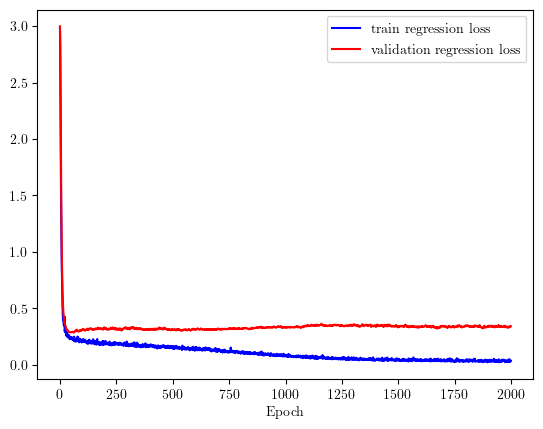

In [12]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [13]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
test_regression_loss,\
test_regression_losses = test(model,
                              device,
                              test_loader,
                              criterion_regression,
                              uncertainty_function)

print("Regression loss: ", test_regression_loss)

Regression loss:  0.28562992811203003


#### Comparing to the worst possible loss

In [14]:
dataset_dir = PROJECT_PATH / "datasets/dataset_multimodal_siamese_png_quantilebinning/traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)
costs = costs_df['traversal_cost'].to_numpy()
mean_dataset_value = costs_df['traversal_cost'].mean()

print(mean_dataset_value)

mean_loss = 0.

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images,\
    traversal_costs,\
    linear_velocities in train_loader_pbar:
    mean_tensor_value = torch.tensor(np.full(list(traversal_costs.shape), mean_dataset_value), dtype=torch.float32)

    #loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    #train_loss += loss.item()
    #
    ## Get the number of correct predictions
    #train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()
    
    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value,
        traversal_costs).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)
    
print(mean_loss)



3.140143006727703


100%|██████████| 5/5 [00:01<00:00,  3.75batch/s]

3.867472267150879


#### Getting some stats about the dataset

## Save model parameters

In [15]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [16]:
##import uncertainty.functions
##import uncertainty.evaluation
##
### Compute the test losses after successive removal of the samples
### with the highest loss and uncertainty
##test_losses_loss, test_losses_uncertainty =\
##    uncertainty.evaluation.uncertainty_relevance(
##        model,
##        device,
##        criterion_regression,
##        uncertainty_function,
##        test,
##        test_set,
##        test_regression_loss,
##        test_regression_losses)

#### Plotting the results

In [17]:
##plt.plot(range(0, 100, 10),
##         test_losses_loss,
##         "bo--",
##         label="removing samples with highest regression loss",
##         markersize=4)
##plt.plot(range(0, 100, 10),
##         test_losses_uncertainty,
##         "ro--",
##         label="removing samples with highest uncertainty",
##         markersize=4)
##
##plt.legend(loc="upper right")
##plt.xlabel("Percentage of samples removed")
##plt.ylabel("Regression error (MSE)")

## Generate a log directory

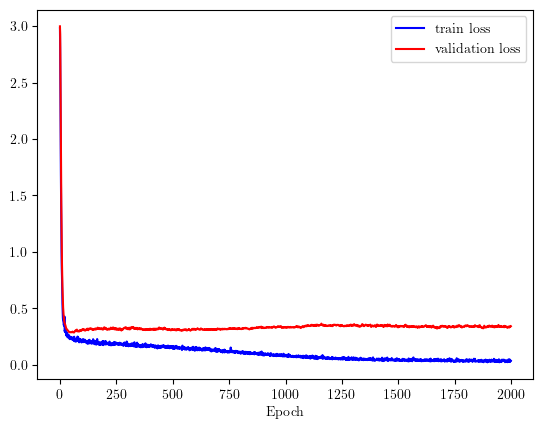

In [18]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values)

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

#### Plotting the results

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")